# Previsioni Fotovoltaiche con Temporal Fusion Transformer (TFT)

## Progetto di Dee  p Learning per Time Series Forecasting

Questo notebook implementa un sistema completo di forecasting per la produzione fotovoltaica utilizzando il modello Temporal Fusion Transformer (TFT). 

**Caratteristiche principali:**
- Forecasting a 24 ore della produzione fotovoltaica
- Cross-validation temporale per validazione robusta 
- Hyperparameter tuning automatico con Optuna
- Interpretabilità del modello con analisi delle attention weights
- MAPE mascherato per correggere il bias notturno

**Pipeline di esecuzione:**
1. Caricamento e preprocessamento dati PV + meteorologici
2. Feature engineering temporale e categoriale 
3. Hyperparameter tuning con validazione temporale
4. Training del modello finale con parametri ottimali
5. Evaluation completa con visualizzazioni
6. Analisi interpretabilità e feature importance

Il sistema supporta diverse modalità di esecuzione tramite flag configurabili, permettendo skip intelligente di fasi già completate per accelerare lo sviluppo iterativo.

## 1. Importazione delle Librerie

Importazione di tutte le librerie necessarie per il progetto di forecasting fotovoltaico con Temporal Fusion Transformer.

**Librerie principali utilizzate:**
- PyTorch Forecasting per il modello TFT
- Pandas per manipolazione dati  
- PyTorch Lightning per training distribuito
- Optuna per hyperparameter tuning
- Plotly per visualizzazioni interattive
- Scikit-learn per metriche di valutazione

In [55]:
# =============================================================================
# CONFIGURAZIONE MODALITÀ DI ESECUZIONE
# =============================================================================

# MODALITÀ OPERATIVE - CONFIGURA QUI PER CONTROLLO PIPELINE
RUN_TUNING_AND_CV = False   # False per saltare hyperparameter tuning + CV se già fatto
RUN_FINAL_TRAINING = False   # True per continuare con training finale

# CARTELLA DI RIFERIMENTO PER SKIP COMPLETO
# Quando entrambi flag sono False: usa questa cartella completamente
REFERENCE_RUN_FOLDER = "run_corretta"  # Cartella con risultati buoni

# PARAMETRI DI CONFIGURAZIONE PRINCIPALI  
CONFIG = {
    # Architettura TFT
    'MAX_ENCODER_LENGTH': 168,    # 1 settimana di contesto (ore)
    'MAX_PREDICTION_LENGTH': 24,  # Previsione 24 ore
    
    # Cross-Validation
    'N_FOLDS': 5,                 # Numero fold temporali
    'VAL_RATIO': 0.2,            # 20% per validation in ogni fold
    
    # Hyperparameter Tuning
    'N_TRIALS': 5,              # Numero trials Optuna (aumentare per risultati migliori)
    'OPTUNA_TIMEOUT_HOURS': 6,   # Timeout massimo per tuning
    
    # MAPE Masking (CRITICO - correzione ore notturne)
    'DAYLIGHT_START_HOUR': 6,    # Ora inizio considerazione MAPE (6:00)
    'DAYLIGHT_END_HOUR': 19,     # Ora fine considerazione MAPE (19:00) 
    'EPS_PV': 5.0,               # Soglia minima potenza kW per MAPE stabile
    
    # Training
    'MAX_EPOCHS_TUNING': 30,     # Epochs per ogni fold durante tuning
    'MAX_EPOCHS_FINAL': 150,     # Epochs per training finale
    'EARLY_STOPPING_PATIENCE': 15,
    
    # Riproducibilità
    'SEED': 42,
    
    # Device
    'ACCELERATOR': 'auto',       # 'auto', 'gpu', 'cpu'
}

print("=" * 70)
print("CONFIGURAZIONE PIPELINE PV FORECASTING")
print("=" * 70)
print(f"RUN_TUNING_AND_CV: {RUN_TUNING_AND_CV}")
print(f"RUN_FINAL_TRAINING: {RUN_FINAL_TRAINING}")

# Controllo modalità speciale
use_existing_results = not RUN_TUNING_AND_CV and not RUN_FINAL_TRAINING

if use_existing_results:
    print(f"Modalità SKIP COMPLETO: Usando cartella di riferimento")
    print(f"Reference folder: {REFERENCE_RUN_FOLDER}")

print(f"\nEncoder Length: {CONFIG['MAX_ENCODER_LENGTH']} hours")
print(f"Prediction Length: {CONFIG['MAX_PREDICTION_LENGTH']} hours")
print(f"N Folds CV: {CONFIG['N_FOLDS']}")
print(f"Optuna Trials: {CONFIG['N_TRIALS']}")
print(f"\nMAPE Masking:")
print(f"   Daylight Hours: {CONFIG['DAYLIGHT_START_HOUR']}:00 - {CONFIG['DAYLIGHT_END_HOUR']}:00")
print(f"   EPS_PV Threshold: {CONFIG['EPS_PV']} kW")
print("=" * 70)

# =============================================================================
# CREAZIONE DIRECTORY RISULTATI CON TIMESTAMP O RIUSO CARTELLA ESISTENTE
# =============================================================================
import os
from pathlib import Path
from datetime import datetime
import json
import shutil

# Gestione diverse modalità
if use_existing_results:
    # Modalità skip completo: usa cartella esistente completamente
    reference_path = Path(f"results/{REFERENCE_RUN_FOLDER}")
    
    if reference_path.exists():
        RESULTS_DIR = reference_path
        
        # Carica configurazione dalla cartella esistente
        config_path = RESULTS_DIR / "config.json"
        if config_path.exists():
            with open(config_path, 'r') as f:
                existing_config = json.load(f)
            
            # Mantieni alcuni parametri dalla configurazione esistente
            for key in ['MAX_ENCODER_LENGTH', 'MAX_PREDICTION_LENGTH', 'N_FOLDS', 
                       'DAYLIGHT_START_HOUR', 'DAYLIGHT_END_HOUR', 'EPS_PV']:
                if key in existing_config:
                    CONFIG[key] = existing_config[key]
            
            timestamp = existing_config.get('TIMESTAMP', REFERENCE_RUN_FOLDER.split('_')[-1])
            print(f"✅ Usando cartella esistente: {RESULTS_DIR}")
            print(f"✅ Configurazione caricata dalla cartella esistente")
        else:
            timestamp = REFERENCE_RUN_FOLDER.split('_')[-1]
            print(f"⚠️ Config non trovato, usando timestamp dalla cartella: {timestamp}")
    else:
        print(f"❌ ERRORE: Cartella di riferimento {reference_path} non trovata!")
        print(f"💡 Creando nuova cartella invece...")
        use_existing_results = False

if not use_existing_results:
    # Modalità standard: crea directory results con timestamp unico
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    RESULTS_DIR = Path(f"results/run_{timestamp}")
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)
    print(f"✅ Nuova cartella creata: {RESULTS_DIR}")

# Sub-directory per organizzazione
FIGURES_DIR = RESULTS_DIR / "figures"
MODELS_DIR = RESULTS_DIR / "models" 
FIGURES_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

print(f"\n📁 Directory risultati: {RESULTS_DIR.absolute()}")
print(f"📁 Figures: {FIGURES_DIR}")
print(f"📁 Models: {MODELS_DIR}")

# Salva/aggiorna configurazione
CONFIG['RESULTS_DIR'] = str(RESULTS_DIR)
CONFIG['FIGURES_DIR'] = str(FIGURES_DIR)
CONFIG['MODELS_DIR'] = str(MODELS_DIR)
CONFIG['TIMESTAMP'] = timestamp
CONFIG['RUN_TUNING_AND_CV'] = RUN_TUNING_AND_CV
CONFIG['RUN_FINAL_TRAINING'] = RUN_FINAL_TRAINING
CONFIG['USE_EXISTING_RESULTS'] = use_existing_results
if use_existing_results:
    CONFIG['REFERENCE_RUN_FOLDER'] = REFERENCE_RUN_FOLDER

config_path = RESULTS_DIR / "config.json"
with open(config_path, 'w') as f:
    json.dump(CONFIG, f, indent=4)

if use_existing_results:
    print(f"📝 Configurazione aggiornata: {config_path}")
    print(f"✅ Modalità RIUSO CARTELLA ESISTENTE attiva")
else:
    print(f"💾 Configurazione salvata: {config_path}")

print(f"\n✅ Setup completato - Run ID: {timestamp}")
if use_existing_results:
    print(f"🔄 Modalità: SKIP COMPLETO usando cartella esistente")
    print(f"📂 Tutti i file necessari saranno caricati da: {RESULTS_DIR}")
else:
    print(f"🔄 Modalità: Standard (nuova esecuzione completa)")

CONFIGURAZIONE PIPELINE PV FORECASTING
RUN_TUNING_AND_CV: False
RUN_FINAL_TRAINING: False
Modalità SKIP COMPLETO: Usando cartella di riferimento
Reference folder: run_corretta

Encoder Length: 168 hours
Prediction Length: 24 hours
N Folds CV: 5
Optuna Trials: 5

MAPE Masking:
   Daylight Hours: 6:00 - 19:00
   EPS_PV Threshold: 5.0 kW
✅ Usando cartella esistente: results\run_corretta
✅ Configurazione caricata dalla cartella esistente

📁 Directory risultati: c:\Users\loren\Desktop\DL_project\src\results\run_corretta
📁 Figures: results\run_corretta\figures
📁 Models: results\run_corretta\models
📝 Configurazione aggiornata: results\run_corretta\config.json
✅ Modalità RIUSO CARTELLA ESISTENTE attiva

✅ Setup completato - Run ID: 20260111_194622
🔄 Modalità: SKIP COMPLETO usando cartella esistente
📂 Tutti i file necessari saranno caricati da: results\run_corretta


## 2. Configurazione Environment e Import Librerie

Importazione di tutte le librerie necessarie per il progetto e configurazione dell'environment di esecuzione.

**Operazioni eseguite:**
- Import delle librerie PyTorch, Lightning, PyTorch Forecasting
- Verifica disponibilità GPU/CUDA
- Configurazione del device di calcolo
- Impostazione seed per riproducibilità
- Visualizzazione versioni librerie per troubleshooting

In [56]:
# Data manipulation e processing
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import warnings
import pickle
import json
import os
import shutil
from pathlib import Path
import gc
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

# PyTorch ecosystem
import torch
import torch.nn as nn

# Fix PyTorch 2.6 - gestione weights_only per compatibilità checkpoint loading
if not hasattr(torch, '_original_load_patched'):
    # Salva riferimento originale solo se non già fatto
    torch._original_load = torch.load
    
    def safe_torch_load(*args, **kwargs):
        # Forza weights_only=False per evitare errori in PyTorch 2.6
        kwargs.setdefault('weights_only', False)
        return torch._original_load(*args, **kwargs)
    
    torch.load = safe_torch_load
    torch._original_load_patched = True
    print("✅ PyTorch 2.6 fix applicato: torch.load ora usa weights_only=False automaticamente")
else:
    print("✅ PyTorch fix già applicato in precedenza")

# PyTorch Lightning - Handle different import styles
try:
    # New style (lightning 2.0+)
    from lightning.pytorch import Trainer, seed_everything
    from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
    from lightning.pytorch.loggers import TensorBoardLogger
    import lightning.pytorch as pl
    print("✓ Using Lightning 2.x imports")
except (ImportError, AttributeError):
    # Fallback to old style
    try:
        from pytorch_lightning import Trainer, seed_everything
        from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
        from pytorch_lightning.loggers import TensorBoardLogger
        import pytorch_lightning as pl
        print("✓ Using PyTorch Lightning 1.x imports")
    except ImportError as e:
        print(f"❌ Lightning import error: {e}")
        raise

# PyTorch Forecasting
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE

# Scikit-learn metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Hyperparameter Optimization
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# Random seed setup for reproducibility
seed_everything(CONFIG['SEED'])
np.random.seed(CONFIG['SEED'])
torch.manual_seed(CONFIG['SEED'])

print(f"\n{'='*70}")
print("📦 PACKAGE VERSIONS & DEVICE INFO")
print(f"{'='*70}")
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"Optuna version: {optuna.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

# GPU/CUDA verification  
print(f"\n🖥️  DEVICE CONFIGURATION:")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU count: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    
    # Test GPU functionality
    test_tensor = torch.randn(3, 3).cuda()
    print(f"✅ GPU test successful: tensor on {test_tensor.device}")
    del test_tensor
    
    device = 'cuda'
else:

    print("⚠️  GPU not available - using CPU")
    print("\n✅ Import e setup completati!")

    device = 'cpu'

print(f"{'='*70}")

print(f"Selected device: {device}")
print(f"Seed set to: {CONFIG['SEED']}")
print(f"{'='*70}")

print("\\n✅ Import e setup completati!")

Seed set to 42


✅ PyTorch fix già applicato in precedenza
✓ Using Lightning 2.x imports

📦 PACKAGE VERSIONS & DEVICE INFO
PyTorch version: 2.7.1+cu118
PyTorch Lightning version: 2.6.0
Optuna version: 4.6.0
NumPy version: 2.3.3
Pandas version: 2.3.3

🖥️  DEVICE CONFIGURATION:
CUDA available: True
CUDA version: 11.8
GPU count: 1
Current GPU: 0
GPU name: NVIDIA GeForce RTX 4070 Laptop GPU
✅ GPU test successful: tensor on cuda:0
Selected device: cuda
Seed set to: 42
\n✅ Import e setup completati!


## 3. Caricamento e Merging dei Dataset

Caricamento dei dataset di produzione fotovoltaica e dati meteorologici con merge temporale.

**Operazioni eseguite:**
- Ricerca automatica dei file CSV nei dataset PV e meteorologici
- Caricamento e parsing dei timestamp
- Merge temporale dei due dataset
- Creazione del dataset unificato con target (power_kw) e features meteorologiche
- Gestione automatica di diverse convenzioni di naming dei file

In [57]:
def find_csv_files():
    """
    Cerca automaticamente i file CSV dei dataset PV e Weather
    Gestisce multiple directory e naming conventions
    """
    print("🔍 Ricerca automatica file CSV...")
    
    # Possibili directory dove cercare
    search_dirs = [
        Path("../data/raw"),
        Path("../data"), 
        Path("./data"),
        Path("."),
        Path(".."),
    ]
    
    found_files = {}
    
    # Patterns per identificare i file
    pv_patterns = ["*pv_dataset*.csv", "*PV*.csv", "*power*.csv"]
    wx_patterns = ["*wx_dataset*.csv", "*weather*.csv", "*meteo*.csv"] 
    
    for search_dir in search_dirs:
        if not search_dir.exists():
            continue
            
        print(f"  📂 Cercando in: {search_dir.absolute()}")
        
        # Cerca file PV
        pv_files = []
        for pattern in pv_patterns:
            pv_files.extend(list(search_dir.glob(pattern)))
        
        # Cerca file Weather
        wx_files = []
        for pattern in wx_patterns:
            wx_files.extend(list(search_dir.glob(pattern)))
            
        if pv_files:
            found_files['pv_files'] = sorted(pv_files)
            print(f"  ✅ PV files: {[f.name for f in pv_files]}")
            
        if wx_files:
            found_files['wx_files'] = sorted(wx_files) 
            print(f"  ✅ Weather files: {[f.name for f in wx_files]}")
            
        # Se trovati entrambi i tipi, stop search
        if 'pv_files' in found_files and 'wx_files' in found_files:
            break
            
    return found_files

def load_and_merge_datasets(found_files):
    """
    Carica e unisce i dataset PV e Weather
    """
    print(f"\n{'='*60}")
    print("📥 CARICAMENTO E MERGE DATASETS")
    print(f"{'='*60}")
    
    # Carica dataset PV
    pv_data_list = []
    for pv_file in found_files['pv_files']:
        print(f"📖 Caricando: {pv_file.name}")
        df = pd.read_csv(pv_file)
        print(f"   Shape: {df.shape}, Colonne: {list(df.columns)}")
        pv_data_list.append(df)
    
    # Concatena dataset PV
    pv_data = pd.concat(pv_data_list, ignore_index=True)
    print(f"\n✅ Dataset PV concatenato: {pv_data.shape}")
    
    # Identifica colonne datetime e target
    datetime_candidates = [col for col in pv_data.columns if any(x in col.lower() for x in ['date', 'time', 'dt', 'timestamp'])]
    
    if not datetime_candidates:
        # Se non trovato, usa prima colonna che sembra temporale
        datetime_candidates = [pv_data.columns[0]]
        
    datetime_col = datetime_candidates[0] 
    
    # Target è la prima colonna numerica che non è datetime
    numeric_cols = pv_data.select_dtypes(include=[np.number]).columns.tolist()
    target_col = numeric_cols[0] if numeric_cols else pv_data.columns[1]
    
    print(f"🎯 Colonna datetime: '{datetime_col}'")
    print(f"🎯 Colonna target: '{target_col}'")
    
    # Rinomina colonne PV
    pv_data = pv_data.rename(columns={datetime_col: 'datetime', target_col: 'power_kw'})
    
    # Carica dataset Weather
    wx_data_list = []
    for wx_file in found_files['wx_files']:
        print(f"📖 Caricando: {wx_file.name}")
        df = pd.read_csv(wx_file)
        print(f"   Shape: {df.shape}")
        wx_data_list.append(df)
    
    # Concatena dataset Weather  
    wx_data = pd.concat(wx_data_list, ignore_index=True)
    print(f"✅ Dataset Weather concatenato: {wx_data.shape}")
    
    # Identifica colonna datetime in weather
    wx_datetime_candidates = [col for col in wx_data.columns if any(x in col.lower() for x in ['date', 'time', 'dt', 'timestamp'])]
    if wx_datetime_candidates:
        wx_data = wx_data.rename(columns={wx_datetime_candidates[0]: 'datetime'})
    
    # Converti datetime con gestione formati misti
    try:
        pv_data['datetime'] = pd.to_datetime(pv_data['datetime'], format='mixed', utc=True).dt.tz_localize(None)
        wx_data['datetime'] = pd.to_datetime(wx_data['datetime'], format='mixed', utc=True).dt.tz_localize(None)
    except:
        # Fallback con inferenza automatica  
        pv_data['datetime'] = pd.to_datetime(pv_data['datetime']).dt.tz_localize(None) if pv_data['datetime'].dtype == 'object' else pv_data['datetime']
        wx_data['datetime'] = pd.to_datetime(wx_data['datetime']).dt.tz_localize(None) if wx_data['datetime'].dtype == 'object' else wx_data['datetime']
    
    # Rimuovi duplicati temporali
    pv_data = pv_data.drop_duplicates(subset=['datetime']).sort_values('datetime').reset_index(drop=True)
    wx_data = wx_data.drop_duplicates(subset=['datetime']).sort_values('datetime').reset_index(drop=True)
    
    print(f"\\n📅 Range PV: {pv_data['datetime'].min()} → {pv_data['datetime'].max()}")
    print(f"📅 Range Weather: {wx_data['datetime'].min()} → {wx_data['datetime'].max()}")
    
    # Merge interno (inner join)
    merged_data = pd.merge(pv_data, wx_data, on='datetime', how='inner')
    merged_data = merged_data.sort_values('datetime').reset_index(drop=True)
    
    print(f"\\n🔗 Dataset mergato: {merged_data.shape}")
    print(f"📊 Periodo finale: {merged_data['datetime'].min()} → {merged_data['datetime'].max()}")
    
    return merged_data

# Esegui caricamento dati
found_files = find_csv_files()

if 'pv_files' not in found_files or 'wx_files' not in found_files:
    print("❌ File mancanti! Assicurati di avere:")
    print("  - File PV: pv_dataset*.csv nella directory data/")
    print("  - File Weather: wx_dataset*.csv nella directory data/") 
    raise FileNotFoundError("Dataset files not found")

# Carica e unisci i dati
data = load_and_merge_datasets(found_files)

print(f"\\n📋 Colonne disponibili:")
for i, col in enumerate(data.columns):
    print(f"  {i+1:2d}. {col}")

print(f"\\n📊 Prime righe del dataset unificato:")
print(data.head())

print(f"\\n✅ Data loading completato - Dataset shape: {data.shape}")

🔍 Ricerca automatica file CSV...
  📂 Cercando in: c:\Users\loren\Desktop\DL_project\src\..\data\raw
  ✅ PV files: ['pv_dataset - 07-10--06-11.csv', 'pv_dataset - 07-11--06-12.csv', 'pv_dataset - 07-10--06-11.csv', 'pv_dataset - 07-11--06-12.csv']
  ✅ Weather files: ['wx_dataset - 07-10--06-11.csv', 'wx_dataset - 07-11--06-12.csv']

📥 CARICAMENTO E MERGE DATASETS
📖 Caricando: pv_dataset - 07-10--06-11.csv
   Shape: (8760, 2), Colonne: ['Max kWp', '82.41']
📖 Caricando: pv_dataset - 07-10--06-11.csv
   Shape: (8760, 2), Colonne: ['Max kWp', '82.41']
📖 Caricando: pv_dataset - 07-11--06-12.csv
   Shape: (8784, 2), Colonne: ['Max kWp', '82.41']
📖 Caricando: pv_dataset - 07-11--06-12.csv
   Shape: (8784, 2), Colonne: ['Max kWp', '82.41']

✅ Dataset PV concatenato: (35088, 2)
🎯 Colonna datetime: 'Max kWp'
🎯 Colonna target: '82.41'
📖 Caricando: wx_dataset - 07-10--06-11.csv
   Shape: (8760, 15)
📖 Caricando: wx_dataset - 07-11--06-12.csv
   Shape: (8784, 15)
✅ Dataset Weather concatenato: (17544

## 4. Analisi Dati e Gestione Valori Mancanti

Analisi esplorativa del dataset unificato e implementazione di strategie per gestire i valori mancanti.

**Operazioni eseguite:**
- Analisi della struttura e completezza del dataset
- Identificazione e quantificazione dei valori mancanti per colonna
- Implementazione di strategie di filling robuste:
  - Interpolazione lineare per serie continue
  - Forward fill per preservare ultima osservazione valida
- Validazione del dataset pulito senza valori mancanti

🔍 Avvio analisi dataset...
📊 ANALISI DATASET
📋 Informazioni generali:
  Shape: (17317, 16)
  Periodo: 2010-07-01 00:00 → 2012-06-30 13:00
  Durata: 730 giorni
\n📊 Tipi colonne:
  Numeriche: 14 - ['power_kw', 'lat', 'lon', 'temp', 'dew_point', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'clouds_all', 'Dhi', 'Dni', 'Ghi']
  Datetime: 1 - ['datetime']
  Object: 1 - ['weather_description']
\n⚡ Analisi target (power_kw):
  Min: 0.00 kW
  Max: 68.92 kW
  Mean: 12.53 kW
  Median: 0.04 kW
  Std: 18.55 kW
  Zero count: 8515
  Negative count: 0
\n======================================================================
🔧 GESTIONE VALORI MANCANTI
⚠️  Valori mancanti trovati:
         Missing_Count  Missing_Percentage
rain_1h          13658           78.870474
✅ rain_1h: NaN → 0 (nessuna pioggia)
\n📊 Risultato finale:
  Dataset originale: 17317 righe
  Dataset pulito: 17317 righe
  Valori mancanti residui: 0
✅ Tutti i valori mancanti gestiti con successo!
\n📈 Creazione preview serie 

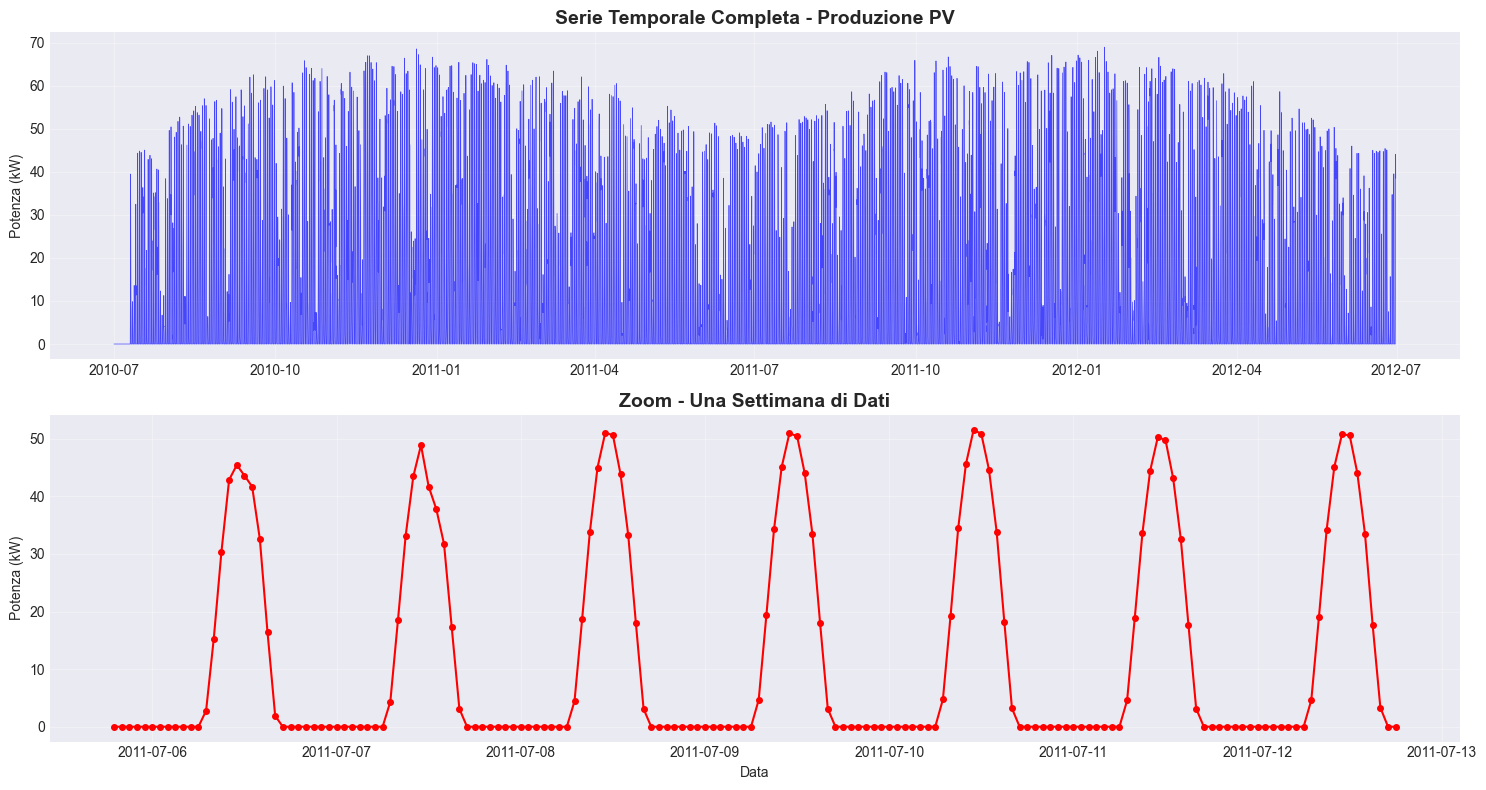

💾 Figura salvata: results\run_corretta\figures\01_data_overview.png
\n✅ Data Analysis completata - Dataset pulito: (17317, 16)


In [58]:
def analyze_dataset(data):
    """
    Analisi completa del dataset con statistiche e quality checks
    """
    print(f"{'='*70}")
    print("📊 ANALISI DATASET")
    print(f"{'='*70}")
    
    print(f"📋 Informazioni generali:")
    print(f"  Shape: {data.shape}")
    print(f"  Periodo: {data['datetime'].min().strftime('%Y-%m-%d %H:%M')} → {data['datetime'].max().strftime('%Y-%m-%d %H:%M')}")
    print(f"  Durata: {(data['datetime'].max() - data['datetime'].min()).days} giorni")
    
    # Identificazione tipi di colonne
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    datetime_cols = data.select_dtypes(include=['datetime64']).columns.tolist()
    object_cols = data.select_dtypes(include=['object']).columns.tolist()
    
    print(f"\\n📊 Tipi colonne:")
    print(f"  Numeriche: {len(numeric_cols)} - {numeric_cols}")
    print(f"  Datetime: {len(datetime_cols)} - {datetime_cols}")
    print(f"  Object: {len(object_cols)} - {object_cols}")
    
    # Analisi target (power_kw)
    if 'power_kw' in data.columns:
        power_stats = {
            'min': data['power_kw'].min(),
            'max': data['power_kw'].max(),
            'mean': data['power_kw'].mean(),
            'median': data['power_kw'].median(),
            'std': data['power_kw'].std(),
            'zero_count': (data['power_kw'] == 0).sum(),
            'negative_count': (data['power_kw'] < 0).sum()
        }
        
        print(f"\\n⚡ Analisi target (power_kw):")
        for key, value in power_stats.items():
            if key in ['min', 'max', 'mean', 'median', 'std']:
                print(f"  {key.capitalize()}: {value:.2f} kW")
            else:
                print(f"  {key.replace('_', ' ').capitalize()}: {value}")
    
    return {
        'numeric_cols': numeric_cols,
        'datetime_cols': datetime_cols, 
        'object_cols': object_cols,
        'power_stats': power_stats if 'power_kw' in data.columns else None
    }

def handle_missing_values(data):
    """
    Gestione robusta dei valori mancanti con strategie multiple
    """
    print(f"\\n{'='*70}")
    print("🔧 GESTIONE VALORI MANCANTI")
    print(f"{'='*70}")
    
    # Controllo valori mancanti
    missing_summary = data.isnull().sum()
    missing_pct = (missing_summary / len(data)) * 100
    
    missing_df = pd.DataFrame({
        'Missing_Count': missing_summary,
        'Missing_Percentage': missing_pct
    })[missing_summary > 0].sort_values('Missing_Count', ascending=False)
    
    if len(missing_df) == 0:
        print("✅ Nessun valore mancante trovato!")
        return data.copy()
    
    print("⚠️  Valori mancanti trovati:")
    print(missing_df)
    
    data_cleaned = data.copy()
    
    # Strategia 1: rain_1h (NaN significa 0 - nessuna pioggia)
    if 'rain_1h' in data_cleaned.columns and data_cleaned['rain_1h'].isnull().any():
        data_cleaned['rain_1h'] = data_cleaned['rain_1h'].fillna(0)
        print("✅ rain_1h: NaN → 0 (nessuna pioggia)")
    
    # Strategia 2: Interpolazione lineare per serie temporali
    numeric_cols = data_cleaned.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        missing_before = data_cleaned[col].isnull().sum()
        if missing_before > 0:
            # Interpolazione lineare limitata (max 3 valori consecutivi)
            data_cleaned[col] = data_cleaned[col].interpolate(
                method='linear', 
                limit=3,  # Max 3 valori consecutivi
                limit_direction='both'
            )
            
            # Forward/backward fill per eventuali gap rimanenti  
            data_cleaned[col] = data_cleaned[col].fillna(method='ffill', limit=2)
            data_cleaned[col] = data_cleaned[col].fillna(method='bfill', limit=2)
            
            missing_after = data_cleaned[col].isnull().sum()
            if missing_after < missing_before:
                print(f"✅ {col}: {missing_before} → {missing_after} missing values")
    
    # Strategia 3: Rimozione righe con troppi NaN rimanenti
    rows_before = len(data_cleaned)
    data_cleaned = data_cleaned.dropna()
    rows_after = len(data_cleaned)
    
    if rows_before != rows_after:
        print(f"🗑️  Rimosse {rows_before - rows_after} righe con NaN residui")
    
    # Verifica finale
    final_missing = data_cleaned.isnull().sum().sum()
    print(f"\\n📊 Risultato finale:")
    print(f"  Dataset originale: {len(data)} righe")
    print(f"  Dataset pulito: {len(data_cleaned)} righe")
    print(f"  Valori mancanti residui: {final_missing}")
    
    if final_missing == 0:
        print("✅ Tutti i valori mancanti gestiti con successo!")
    else:
        print("⚠️  Alcuni valori mancanti potrebbero rimanere")
    
    return data_cleaned

# Esegui analisi dataset
print("🔍 Avvio analisi dataset...")
dataset_info = analyze_dataset(data)

# Gestisci valori mancanti
data_clean = handle_missing_values(data)

# Visualizzazione rapida della serie temporale target
if 'power_kw' in data_clean.columns:
    print("\\n📈 Creazione preview serie temporale...")
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    
    # Serie completa
    ax1.plot(data_clean['datetime'], data_clean['power_kw'], linewidth=0.5, alpha=0.7, color='blue')
    ax1.set_title('Serie Temporale Completa - Produzione PV', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Potenza (kW)')
    ax1.grid(True, alpha=0.3)
    
    # Zoom su una settimana (sample)
    sample_start = len(data_clean) // 2
    sample_end = min(sample_start + 168, len(data_clean))  # 1 settimana o fino alla fine
    
    sample_data = data_clean.iloc[sample_start:sample_end]
    ax2.plot(sample_data['datetime'], sample_data['power_kw'], 
             marker='o', markersize=4, linewidth=1.5, color='red')
    ax2.set_title('Zoom - Una Settimana di Dati', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Data')
    ax2.set_ylabel('Potenza (kW)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Salva figura
    fig_path = FIGURES_DIR / "01_data_overview.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"💾 Figura salvata: {fig_path}")

print(f"\\n✅ Data Analysis completata - Dataset pulito: {data_clean.shape}")

# Aggiorna la variabile principale
data = data_clean

## 5. Feature Engineering

Creazione di feature temporali e trasformazione dei dati per ottimizzare le performance del modello TFT.

**Feature temporali create:**
- Encoding ciclico di ora, giorno settimana, mese (sin/cos)
- Feature temporali discrete per catturare pattern stagionali
- Normalizzazione variabili meteorologiche con scaling fisico appropriato

**Output:** Dataset con tutte le feature necessarie per il training del modello TFT

In [59]:
def create_temporal_features(data):
    """
    Crea features temporali ciclici per catturare seasonalità
    """
    print(f"{'='*70}")
    print("🕐 CREAZIONE FEATURES TEMPORALI CICLICI")
    print(f"{'='*70}")
    
    data_fe = data.copy()
    
    # Estrai componenti temporali
    data_fe['hour'] = data_fe['datetime'].dt.hour
    data_fe['day_of_year'] = data_fe['datetime'].dt.dayofyear
    data_fe['month'] = data_fe['datetime'].dt.month
    data_fe['day_of_week'] = data_fe['datetime'].dt.dayofweek
    
    # Encoding ciclici (sin/cos) per preservare continuità
    
    # 1. Hour (0-23, periodo 24)
    data_fe['hour_sin'] = np.sin(2 * np.pi * data_fe['hour'] / 24)
    data_fe['hour_cos'] = np.cos(2 * np.pi * data_fe['hour'] / 24)
    
    # 2. Day of year (1-365, periodo 365)
    data_fe['day_sin'] = np.sin(2 * np.pi * (data_fe['day_of_year'] - 1) / 365)
    data_fe['day_cos'] = np.cos(2 * np.pi * (data_fe['day_of_year'] - 1) / 365)
    
    # 3. Month (1-12, periodo 12)
    data_fe['month_sin'] = np.sin(2 * np.pi * (data_fe['month'] - 1) / 12)
    data_fe['month_cos'] = np.cos(2 * np.pi * (data_fe['month'] - 1) / 12)
    
    # 4. Day of week (0-6, periodo 7)
    data_fe['dow_sin'] = np.sin(2 * np.pi * data_fe['day_of_week'] / 7)
    data_fe['dow_cos'] = np.cos(2 * np.pi * data_fe['day_of_week'] / 7)
    
    # 5. Wind direction (se disponibile)
    if any(col for col in data_fe.columns if 'wind' in col.lower() and 'deg' in col.lower()):
        wind_deg_cols = [col for col in data_fe.columns if 'wind' in col.lower() and 'deg' in col.lower()]
        wind_deg_col = wind_deg_cols[0]
        
        data_fe['wind_sin'] = np.sin(2 * np.pi * data_fe[wind_deg_col] / 360)
        data_fe['wind_cos'] = np.cos(2 * np.pi * data_fe[wind_deg_col] / 360)
        print(f"✅ Wind direction encoding: {wind_deg_col} → wind_sin/cos")
    
    temporal_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 
                        'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
    
    if 'wind_sin' in data_fe.columns:
        temporal_features.extend(['wind_sin', 'wind_cos'])
    
    print(f"✅ Features temporali creati: {len(temporal_features)}")
    print(f"  {temporal_features}")
    
    return data_fe

def apply_physics_based_scaling(data):
    """
    Applica scaling basato su principi fisici per features meteo
    """
    print(f"\\n{'='*70}")
    print("🔬 PHYSICS-BASED SCALING")
    print(f"{'='*70}")
    
    data_scaled = data.copy()
    scaling_info = {}
    
    # 1. Irradiance scaling (normalizza per costante solare)
    SOLAR_CONSTANT = 1361  # W/m²
    irradiance_cols = ['Ghi', 'Dni', 'Dhi', 'ghi', 'dni', 'dhi']
    
    for col in data_scaled.columns:
        if any(irr in col for irr in irradiance_cols):
            if data_scaled[col].max() > 10:  # Verifica che sia in W/m² (non già normalizzato)
                original_range = [data_scaled[col].min(), data_scaled[col].max()]
                data_scaled[col] = data_scaled[col] / SOLAR_CONSTANT
                scaling_info[col] = f"Normalizzato per costante solare ({SOLAR_CONSTANT} W/m²)"
                print(f"✅ {col}: {original_range[0]:.0f}-{original_range[1]:.0f} W/m² → {data_scaled[col].min():.3f}-{data_scaled[col].max():.3f}")
    
    # 2. Temperature scaling (K → °C se necessario)
    temp_cols = ['temp', 'temperature', 'dew_point']
    for col in data_scaled.columns:
        if any(temp in col.lower() for temp in temp_cols):
            if data_scaled[col].min() > 200:  # Probabilmente in Kelvin
                data_scaled[col] = data_scaled[col] - 273.15
                scaling_info[col] = "Convertito da Kelvin a Celsius"
                print(f"✅ {col}: Kelvin → Celsius")
    
    # 3. Percentage scaling (0-100 → 0-1)
    percentage_cols = ['humidity', 'clouds_all', 'clouds']
    for col in data_scaled.columns:
        if any(pct in col.lower() for pct in percentage_cols):
            if data_scaled[col].max() > 1.5:  # Probabilmente in percentuale
                original_range = [data_scaled[col].min(), data_scaled[col].max()]
                data_scaled[col] = data_scaled[col] / 100.0
                scaling_info[col] = "Convertito da % (0-100) a frazione (0-1)"
                print(f"✅ {col}: {original_range[0]:.1f}-{original_range[1]:.1f}% → {data_scaled[col].min():.3f}-{data_scaled[col].max():.3f}")
    
    # 4. Log transformation per variabili skewed
    skewed_cols = ['rain_1h', 'wind_speed']
    for col in data_scaled.columns:
        if any(skewed in col.lower() for skewed in skewed_cols):
            # Verifica skewness
            from scipy.stats import skew
            col_skew = skew(data_scaled[col].dropna())
            if abs(col_skew) > 1.0:  # Significativamente skewed
                original_range = [data_scaled[col].min(), data_scaled[col].max()]
                data_scaled[col] = np.log1p(data_scaled[col])  # log(1 + x)
                scaling_info[col] = f"Log1p transform (skewness: {col_skew:.2f})"
                print(f"✅ {col}: log1p transform (skewness {col_skew:.2f})")
    
    print(f"\\n📊 Scaling applicato a {len(scaling_info)} colonne")
    
    return data_scaled, scaling_info

def prepare_tft_features(data):
    """
    Prepara le features per TimeSeriesDataSet e TFT
    """
    print(f"\\n{'='*70}")
    print("🎯 PREPARAZIONE FEATURES TFT")
    print(f"{'='*70}")
    
    data_tft = data.copy()
    
    # Aggiungi metadata richiesti da PyTorch Forecasting
    
    # 1. Group ID (necessario per GroupNormalizer)
    data_tft['group_id'] = 'PV_System_1'
    
    # 2. Time index (indice temporale incrementale)
    data_tft = data_tft.sort_values('datetime').reset_index(drop=True)
    data_tft['time_idx'] = range(len(data_tft))
    
    # Converti time_idx a int per compatibilità
    data_tft['time_idx'] = data_tft['time_idx'].astype(int)
    
    # 3. Identificazione categoriche e numeriche per TFT
    
    # Static categoricals (non cambiano nel tempo)
    static_categoricals = ['group_id']
    
    # Time-varying known reals (note nel futuro)
    time_varying_known_reals = [
        'time_idx',      # Richiesto da PyTorch Forecasting
        'hour_sin', 'hour_cos',     # Ora del giorno  
        'day_sin', 'day_cos',       # Giorno dell'anno
        'month_sin', 'month_cos',   # Mese
        'dow_sin', 'dow_cos',       # Giorno settimana
    ]
    
    # Aggiungi wind direction se presente
    if 'wind_sin' in data_tft.columns:
        time_varying_known_reals.extend(['wind_sin', 'wind_cos'])
    
    # Time-varying unknown reals (incerte nel futuro)
    time_varying_unknown_reals = ['power_kw']  # Target
    
    # Aggiungi tutte le features meteo disponibili
    weather_features = []
    for col in data_tft.columns:
        if col not in ['datetime', 'group_id', 'time_idx', 'power_kw'] + time_varying_known_reals:
            if data_tft[col].dtype in ['float64', 'float32', 'int64', 'int32']:
                weather_features.append(col)
    
    time_varying_unknown_reals.extend(weather_features)
    
    # 4. Ottimizzazione dtypes per performance
    for col in time_varying_known_reals + time_varying_unknown_reals:
        if col in data_tft.columns and col != 'time_idx':
            data_tft[col] = data_tft[col].astype(np.float32)
    
    # Summary features
    feature_summary = {
        'static_categoricals': static_categoricals,
        'time_varying_known_reals': time_varying_known_reals,
        'time_varying_unknown_reals': time_varying_unknown_reals,
        'total_features': len(time_varying_known_reals) + len(time_varying_unknown_reals) - 1  # -1 per time_idx
    }
    
    print(f"📋 Features configurate per TFT:")
    print(f"  Static categoricals: {len(static_categoricals)}")
    print(f"  Known reals: {len(time_varying_known_reals)}")
    print(f"  Unknown reals: {len(time_varying_unknown_reals)}")
    print(f"  Total features: {feature_summary['total_features']}")
    
    print(f"\\n🕐 Time-varying known reals: {time_varying_known_reals[:5]}...")
    print(f"🌦️  Time-varying unknown reals: {time_varying_unknown_reals[:5]}...")
    
    return data_tft, feature_summary

# Esecuzione Feature Engineering
print("🚀 Avvio Feature Engineering...")

# Step 1: Features temporali
print("\\n1️⃣ Creazione features temporali...")
data = create_temporal_features(data)

# Step 2: Physics-based scaling  
print("\\n2️⃣ Applicazione scaling fisico...")
data, scaling_info = apply_physics_based_scaling(data)

# Step 3: Preparazione per TFT
print("\\n3️⃣ Preparazione features TFT...")
data, feature_summary = prepare_tft_features(data)

# Salva feature summary
feature_summary_path = RESULTS_DIR / "feature_summary.json"
with open(feature_summary_path, 'w') as f:
    json.dump(feature_summary, f, indent=4)

scaling_info_path = RESULTS_DIR / "scaling_info.json"  
with open(scaling_info_path, 'w') as f:
    json.dump(scaling_info, f, indent=4)

print(f"\\n💾 Feature summary salvato: {feature_summary_path}")
print(f"💾 Scaling info salvato: {scaling_info_path}")

print(f"\\n📊 Dataset finale dopo Feature Engineering:")
print(f"  Shape: {data.shape}")
print(f"  Periodo: {data['datetime'].min().strftime('%Y-%m-%d %H:%M')} → {data['datetime'].max().strftime('%Y-%m-%d %H:%M')}")
print(f"  Features totali: {feature_summary['total_features']}")

print(f"\\n✅ Feature Engineering completato!")

# Store nelle variabili globali per le fasi successive
STATIC_CATEGORICALS = feature_summary['static_categoricals'] 
TIME_VARYING_KNOWN_REALS = feature_summary['time_varying_known_reals']
TIME_VARYING_UNKNOWN_REALS = feature_summary['time_varying_unknown_reals']

🚀 Avvio Feature Engineering...
\n1️⃣ Creazione features temporali...
🕐 CREAZIONE FEATURES TEMPORALI CICLICI
✅ Wind direction encoding: wind_deg → wind_sin/cos
✅ Features temporali creati: 10
  ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'wind_sin', 'wind_cos']
\n2️⃣ Applicazione scaling fisico...
\n======================================================================
🔬 PHYSICS-BASED SCALING
✅ Dhi: 0-596 W/m² → 0.000-0.438
✅ Dni: 0-1048 W/m² → 0.000-0.770
✅ Ghi: 0-1109 W/m² → 0.000-0.815
✅ temp: Kelvin → Celsius
✅ dew_point: Kelvin → Celsius
✅ humidity: 17.0-100.0% → 0.170-1.000
✅ clouds_all: 0.0-100.0% → 0.000-1.000
✅ rain_1h: log1p transform (skewness 5.84)
\n📊 Scaling applicato a 8 colonne
\n3️⃣ Preparazione features TFT...
\n======================================================================
🎯 PREPARAZIONE FEATURES TFT
📋 Features configurate per TFT:
  Static categoricals: 1
  Known reals: 11
  Unknown reals: 18
  Total features

## 6. Definizione Metriche MAPE Mascherato

Implementazione della metrica MAPE mascherato per correggere il bias nelle ore notturne.

**Problema del MAPE notturno:**
Durante le ore notturne la produzione fotovoltaica è praticamente zero (assenza di irraggiamento solare). Il calcolo del MAPE tradizionale (|y_true - y_pred| / y_true) comporta divisioni per valori prossimi allo zero, causando esplosioni numeriche che rendono la metrica non interpretabile.

**Soluzione adottata:**
- **Maschera temporale**: Consideriamo solo le ore diurne (6:00-19:00)  
- **Soglia di potenza**: Includiamo solo osservazioni con potenza > 5.0 kW
- **MAPE mascherato**: Calcolato solo sulle osservazioni che soddisfano entrambe le condizioni

Questa strategia fornisce una metrica MAPE robusta e interpretabile focalizzata sulle ore di effettiva produzione fotovoltaica.

In [60]:
def create_temporal_cv_splits(data, n_folds=5, val_ratio=0.2):
    """
    Crea split temporali per cross-validation senza data leakage
    """
    print(f"{'='*70}")
    print("⏰ TEMPORAL CROSS-VALIDATION SPLITS")
    print(f"{'='*70}")
    
    data_sorted = data.sort_values('time_idx').reset_index(drop=True)
    total_samples = len(data_sorted)
    val_size = int(total_samples * val_ratio)
    
    print(f"📊 Dataset info:")
    print(f"  Total samples: {total_samples}")
    print(f"  Validation size per fold: {val_size} ({val_ratio*100:.1f}%)")
    print(f"  Min encoder length: {CONFIG['MAX_ENCODER_LENGTH']}")
    print(f"  Min prediction length: {CONFIG['MAX_PREDICTION_LENGTH']}")
    
    folds = []
    
    # Calcola dimensioni progressive del training set
    min_train_size = int(total_samples * 0.4)  # Min 40% per training
    max_train_size = total_samples - val_size   # Max possibile
    
    for fold_idx in range(n_folds):
        # Training size cresce progressivamente  
        progress = fold_idx / (n_folds - 1) if n_folds > 1 else 0
        train_size = int(min_train_size + progress * (max_train_size - min_train_size))
        
        # Calcola cutoff indices
        train_cutoff_idx = train_size - 1
        val_start_idx = train_cutoff_idx + 1  
        val_end_idx = min(val_start_idx + val_size - 1, total_samples - 1)
        
        # Verifica che ci siano abbastanza samples
        if train_cutoff_idx < CONFIG['MAX_ENCODER_LENGTH'] + CONFIG['MAX_PREDICTION_LENGTH']:
            print(f"⚠️  Fold {fold_idx + 1}: Training set troppo piccolo, skipping")
            continue
            
        if val_end_idx - val_start_idx + 1 < CONFIG['MAX_PREDICTION_LENGTH'] * 3:
            print(f"⚠️  Fold {fold_idx + 1}: Validation set troppo piccolo, skipping") 
            continue
        
        # Crea split
        train_data = data_sorted.iloc[:train_cutoff_idx + 1].copy()
        val_data = data_sorted.iloc[val_start_idx:val_end_idx + 1].copy()
        
        # Aggiusta time_idx per essere consecutivo in ogni split
        train_data['time_idx'] = range(len(train_data))
        val_data['time_idx'] = range(len(train_data), len(train_data) + len(val_data))
        
        folds.append({
            'fold_idx': fold_idx,
            'train_data': train_data,
            'val_data': val_data,
            'train_samples': len(train_data),
            'val_samples': len(val_data),
            'train_range': (train_data['datetime'].min(), train_data['datetime'].max()),
            'val_range': (val_data['datetime'].min(), val_data['datetime'].max())
        })
        
        print(f"✅ Fold {fold_idx + 1}:")
        print(f"   Train: {len(train_data)} samples ({len(train_data)/total_samples*100:.1f}%)")
        print(f"   Val: {len(val_data)} samples ({len(val_data)/total_samples*100:.1f}%)")
        print(f"   Period: {train_data['datetime'].min().strftime('%Y-%m-%d')} → {val_data['datetime'].max().strftime('%Y-%m-%d')}")
    
    print(f"\\n✅ Creati {len(folds)} fold validi per temporal CV")
    return folds

def build_timeseries_dataset(train_data, val_data=None, predict_mode=False):
    """
    Costruisce TimeSeriesDataSet con GroupNormalizer per evitare data leakage
    """
    # Training dataset
    training_dataset = TimeSeriesDataSet(
        train_data,
        time_idx='time_idx',
        target='power_kw', 
        group_ids=STATIC_CATEGORICALS,
        min_encoder_length=CONFIG['MAX_ENCODER_LENGTH'],
        max_encoder_length=CONFIG['MAX_ENCODER_LENGTH'],
        min_prediction_length=CONFIG['MAX_PREDICTION_LENGTH'],
        max_prediction_length=CONFIG['MAX_PREDICTION_LENGTH'],
        
        # Feature configuration
        static_categoricals=STATIC_CATEGORICALS,
        time_varying_known_reals=TIME_VARYING_KNOWN_REALS,
        time_varying_unknown_reals=TIME_VARYING_UNKNOWN_REALS,
        
        # GroupNormalizer per evitare data leakage 
        # Calcola mean/std SOLO sui dati di training
        target_normalizer=GroupNormalizer(
            groups=STATIC_CATEGORICALS,
            transformation='softplus',  # Ottimo per dati di potenza (sempre positivi)
            center=True                 # z-score normalization
        ),
        
        # Aggiungi features automatiche
        add_relative_time_idx=True,
        add_target_scales=True, 
        add_encoder_length=True,
    )
    
    if val_data is not None and not predict_mode:
        # Validation dataset (per training)
        combined_data = pd.concat([train_data, val_data]).sort_values('time_idx')
        validation_dataset = TimeSeriesDataSet.from_dataset(
            training_dataset,
            combined_data,
            predict=False,
            stop_randomization=True
        )
        return training_dataset, validation_dataset
        
    elif val_data is not None and predict_mode:
        # Prediction dataset (per inference) 
        combined_data = pd.concat([train_data, val_data]).sort_values('time_idx')
        prediction_dataset = TimeSeriesDataSet.from_dataset(
            training_dataset,
            combined_data, 
            predict=True,
            stop_randomization=True
        )
        return training_dataset, prediction_dataset
    
    return training_dataset

# Crea temporal CV splits
print("🔄 Creazione temporal cross-validation splits...")
cv_folds = create_temporal_cv_splits(data, n_folds=CONFIG['N_FOLDS'], val_ratio=CONFIG['VAL_RATIO'])

# Test build dataset sul primo fold
if cv_folds:
    print(f"\\n🧪 Test TimeSeriesDataSet sul primo fold...")
    
    first_fold = cv_folds[0]
    train_dataset, val_dataset = build_timeseries_dataset(
        first_fold['train_data'], 
        first_fold['val_data']
    )
    
    print(f"✅ TimeSeriesDataSet build successful:")
    print(f"  Training sequences: {len(train_dataset)}")
    print(f"  Validation sequences: {len(val_dataset)}")
    print(f"  Encoder length: {train_dataset.max_encoder_length}")
    print(f"  Prediction length: {train_dataset.max_prediction_length}")
    print(f"  Features: {len(train_dataset.reals)} reals")
    
    # Pulisci memoria
    del train_dataset, val_dataset

print(f"\\n✅ Pre-processing per TFT completato!")

# Salva CV splits per riutilizzo
cv_splits_path = RESULTS_DIR / "cv_splits.pkl"
with open(cv_splits_path, 'wb') as f:
    pickle.dump(cv_folds, f)
    
print(f"💾 CV splits salvati: {cv_splits_path}")

print(f"\\n📊 Ready for hyperparameter tuning con {len(cv_folds)} fold temporali")

🔄 Creazione temporal cross-validation splits...
⏰ TEMPORAL CROSS-VALIDATION SPLITS
📊 Dataset info:
  Total samples: 17317
  Validation size per fold: 3463 (20.0%)
  Min encoder length: 168
  Min prediction length: 24
✅ Fold 1:
   Train: 6926 samples (40.0%)
   Val: 3463 samples (20.0%)
   Period: 2010-07-01 → 2011-09-15
✅ Fold 2:
   Train: 8658 samples (50.0%)
   Val: 3463 samples (20.0%)
   Period: 2010-07-01 → 2011-11-27
✅ Fold 3:
   Train: 10390 samples (60.0%)
   Val: 3463 samples (20.0%)
   Period: 2010-07-01 → 2012-02-07
✅ Fold 4:
   Train: 12122 samples (70.0%)
   Val: 3463 samples (20.0%)
   Period: 2010-07-01 → 2012-04-19
✅ Fold 5:
   Train: 13854 samples (80.0%)
   Val: 3463 samples (20.0%)
   Period: 2010-07-01 → 2012-06-30
\n✅ Creati 5 fold validi per temporal CV
\n🧪 Test TimeSeriesDataSet sul primo fold...
✅ TimeSeriesDataSet build successful:
  Training sequences: 6735
  Validation sequences: 10198
  Encoder length: 168
  Prediction length: 24
  Features: 33 reals
\n✅ Pre

## 7. Definizione Search Space per Hyperparameter Tuning

Definizione dello spazio di ricerca per l'ottimizzazione automatica degli iperparametri con Optuna.

**Parametri ottimizzati:**
- **Architettura TFT**: hidden_size, num_attention_heads, dropout
- **Training**: learning_rate, batch_size, weight_decay  
- **Regularizzazione**: gradient_clip_val per stabilità numerica
- **Ottimizzatore**: configurazione AdamW con parametri adattivi

La funzione `suggest_hyperparameters()` fornisce campionamento Bayesiano intelligente per esplorare efficacemente lo spazio dei parametri.

In [61]:
def suggest_hyperparameters(trial):
    """
    Definisce search space per hyperparameter optimization con Optuna
    
    Returns:
        dict: Hyperparameters suggeriti per questo trial
    """
    # Architettura TFT
    hyperparams = {
        # Dimensioni rete
        'hidden_size': trial.suggest_categorical('hidden_size', [64, 128, 192, 256]),
        'lstm_layers': trial.suggest_int('lstm_layers', 1, 3),
        'attention_head_size': trial.suggest_categorical('attention_head_size', [1, 2, 4, 8]),
        'hidden_continuous_size': trial.suggest_categorical('hidden_continuous_size', [8, 16, 32, 64]),
        
        # Regolarizzazione
        'dropout': trial.suggest_float('dropout', 0.1, 0.4),
        'gradient_clip_val': trial.suggest_float('gradient_clip_val', 0.1, 2.0),
        
        # Training hyperparameters  
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        
        # Early stopping
        'patience': trial.suggest_int('patience', 8, 20),
        
        # Optimizer specifics
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
    }
    
    return hyperparams

# Visualizza search space
print(f"{'='*70}")
print("🎯 HYPERPARAMETER SEARCH SPACE")  
print(f"{'='*70}")

sample_params = {
    'hidden_size': [64, 128, 192, 256],
    'lstm_layers': [1, 2, 3],
    'attention_head_size': [1, 2, 4, 8], 
    'hidden_continuous_size': [8, 16, 32, 64],
    'dropout': [0.1, 0.4],
    'gradient_clip_val': [0.1, 2.0],
    'learning_rate': [1e-4, 1e-2],
    'batch_size': [32, 64, 128],
    'patience': [8, 20],
    'weight_decay': [1e-6, 1e-3]
}

print("📋 Parametri da ottimizzare:")
for param, values in sample_params.items():
    if param in ['learning_rate', 'weight_decay']:
        print(f"  {param:20s}: {values[0]:.0e} - {values[1]:.0e} (log scale)")
    elif param in ['dropout', 'gradient_clip_val']:
        print(f"  {param:20s}: {values[0]} - {values[1]} (continuous)")
    else:
        print(f"  {param:20s}: {values}")

# Stima dimensioni search space
total_combinations = 1
for param, values in sample_params.items():
    if param in ['hidden_size', 'attention_head_size', 'hidden_continuous_size', 'batch_size']:
        total_combinations *= len(values)
    elif param == 'lstm_layers':
        total_combinations *= 3
    elif param == 'patience':
        total_combinations *= 13  # 8-20 range
    else:
        total_combinations *= 20  # Approximate for continuous params

print(f"\\n📊 Search space info:")
print(f"  Discrete combinations: ~{total_combinations:,}")
print(f"  Planned trials: {CONFIG['N_TRIALS']}")
print(f"  Coverage: {CONFIG['N_TRIALS']/total_combinations*100:.3f}%")
print(f"  Expected duration: ~{CONFIG['N_TRIALS'] * len(cv_folds) * CONFIG['MAX_EPOCHS_TUNING'] / 60:.1f} minutes")

print(f"\\n✅ Hyperparameter search space configurato!")

print(f"\\n🎲 Test sample hyperparameters:")
# Test sample di hyperparameters (senza Optuna trial)
class MockTrial:
    def suggest_categorical(self, name, choices):
        return np.random.choice(choices)
    def suggest_int(self, name, low, high):  
        return np.random.randint(low, high + 1)
    def suggest_float(self, name, low, high, log=False):
        if log:
            return np.random.lognormal(np.log(low), 0.5)
        return np.random.uniform(low, high)

mock_trial = MockTrial()
sample_hyperparams = suggest_hyperparameters(mock_trial)

for param, value in sample_hyperparams.items():
    if isinstance(value, float):
        print(f"  {param:20s}: {value:.6f}")
    else:
        print(f"  {param:20s}: {value}")

print(f"\\n⚙️  Search space pronto per Optuna optimization!")

🎯 HYPERPARAMETER SEARCH SPACE
📋 Parametri da ottimizzare:
  hidden_size         : [64, 128, 192, 256]
  lstm_layers         : [1, 2, 3]
  attention_head_size : [1, 2, 4, 8]
  hidden_continuous_size: [8, 16, 32, 64]
  dropout             : 0.1 - 0.4 (continuous)
  gradient_clip_val   : 0.1 - 2.0 (continuous)
  learning_rate       : 1e-04 - 1e-02 (log scale)
  batch_size          : [32, 64, 128]
  patience            : [8, 20]
  weight_decay        : 1e-06 - 1e-03 (log scale)
\n📊 Search space info:
  Discrete combinations: ~1,198,080,000
  Planned trials: 5
  Coverage: 0.000%
  Expected duration: ~12.5 minutes
\n✅ Hyperparameter search space configurato!
\n🎲 Test sample hyperparameters:
  hidden_size         : 192
  lstm_layers         : 1
  attention_head_size : 4
  hidden_continuous_size: 32
  dropout             : 0.333907
  gradient_clip_val   : 1.234015
  learning_rate       : 0.000063
  batch_size          : 128
  patience            : 15
  weight_decay        : 0.000001
\n⚙️  Sear

## 8. Funzione Obiettivo per Cross-Validation

Implementazione della funzione obiettivo per Optuna che integra cross-validation temporale con MAPE mascherato.

**Caratteristiche principali:**
- **Cross-validation temporale**: Valutazione su tutti i fold per robustezza
- **MAPE mascherato**: Metrica primaria che esclude ore notturne e bassa produzione
- **Metriche multiple**: Calcolo di MAE, RMSE, SMAPE oltre al MAPE mascherato  
- **Early stopping**: Integrato per evitare overfitting durante l'ottimizzazione
- **Gestione errori**: Robusta per gestire trial falliti senza interrompere l'ottimizzazione

La funzione restituisce il MAPE mascherato mediato su tutti i fold come obiettivo da minimizzare per Optuna.

In [62]:
def evaluate_predictions_with_masked_mape(y_true, y_pred, timestamps=None):
    """
    Calcola metriche di evaluation con MAPE mascherato per ore diurne
    
    Args:
        y_true: Valori reali (shape: [n_sequences, horizon] o [n_samples])
        y_pred: Predizioni (shape: [n_sequences, horizon] o [n_samples]) 
        timestamps: Array di timestamp per identificare ore (optional)
        
    Returns:
        dict: Dizionario con tutte le metriche, incluso MAPE_masked
    """
    # Converti a numpy arrays se necessario
    if hasattr(y_true, 'cpu'):
        y_true = y_true.cpu().numpy()
    if hasattr(y_pred, 'cpu'):
        y_pred = y_pred.cpu().numpy()
    
    # Debug shapes
    print(f"     DEBUG - y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")
    
    # Gestisci shape mismatch - assicurati che abbiano la stessa forma
    if y_true.shape != y_pred.shape:
        print(f"     WARNING - Shape mismatch detected, attempting to fix...")
        
        # Se y_true ha dimensioni extra, prendi solo la porzione che corrisponde
        if len(y_true.shape) > len(y_pred.shape):
            if y_pred.ndim == 2:  # [batch, time]
                y_true = y_true[:y_pred.shape[0], :y_pred.shape[1]]
            elif y_pred.ndim == 1:  # [samples]
                y_true = y_true.flatten()[:len(y_pred)]
                
        # Se y_pred ha dimensioni extra, prendi solo la porzione che corrisponde  
        elif len(y_pred.shape) > len(y_true.shape):
            if y_true.ndim == 2:  # [batch, time]
                y_pred = y_pred[:y_true.shape[0], :y_true.shape[1]]
            elif y_true.ndim == 1:  # [samples]
                y_pred = y_pred.flatten()[:len(y_true)]
        
        # Se hanno stesse dimensioni ma forme diverse
        else:
            min_size = min(y_true.size, y_pred.size)
            y_true = y_true.flatten()[:min_size]
            y_pred = y_pred.flatten()[:min_size]
    
    # Flatten se necessario per calcolo metriche
    if len(y_true.shape) > 1:
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()
    else:
        y_true_flat = y_true
        y_pred_flat = y_pred
    
    # Verifica finale delle dimensioni
    if len(y_true_flat) != len(y_pred_flat):
        print(f"     ERROR - Still have dimension mismatch: {len(y_true_flat)} vs {len(y_pred_flat)}")
        # Truncate al minimo comune
        min_len = min(len(y_true_flat), len(y_pred_flat))
        y_true_flat = y_true_flat[:min_len]
        y_pred_flat = y_pred_flat[:min_len]
    
    print(f"     DEBUG - Final shapes: y_true_flat: {y_true_flat.shape}, y_pred_flat: {y_pred_flat.shape}")
    
    # Metriche standard (sempre)
    mae = mean_absolute_error(y_true_flat, y_pred_flat) 
    rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    r2 = r2_score(y_true_flat, y_pred_flat)
    
    # MAPE raw (con epsilon per stabilità)
    mape_raw = np.mean(np.abs((y_true_flat - y_pred_flat) / (y_true_flat + 1e-3))) * 100
    
    # MAPE mascherato (CRITICO - esclude ore notturne)
    if timestamps is not None:
        try:
            # Usa timestamps reali per identificare ore
            if hasattr(timestamps, 'flatten'):
                timestamps_flat = timestamps.flatten()
            else:
                timestamps_flat = timestamps
                
            # Assicurati che timestamps abbiano stessa lunghezza delle predictions
            if len(timestamps_flat) != len(y_true_flat):
                # Genera timestamps artificiali se necessario
                print(f"     WARNING - Timestamp length mismatch, generating artificial timestamps")
                timestamps_flat = pd.date_range(start='2023-01-01', periods=len(y_true_flat), freq='H')
                
            # Estrai ore dai timestamps
            if hasattr(timestamps_flat[0], 'hour'):
                hours = np.array([t.hour for t in timestamps_flat])
            else:
                hours = pd.to_datetime(timestamps_flat).hour.values
            
            # Maschera daylight + soglia potenza
            daylight_mask = (hours >= CONFIG['DAYLIGHT_START_HOUR']) & (hours <= CONFIG['DAYLIGHT_END_HOUR'])
            power_mask = y_true_flat > CONFIG['EPS_PV']
            final_mask = daylight_mask & power_mask
            
            if final_mask.sum() > 0:
                y_true_masked = y_true_flat[final_mask]
                y_pred_masked = y_pred_flat[final_mask]
                mape_masked = np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked)) * 100
                valid_points = final_mask.sum()
            else:
                mape_masked = mape_raw  # Fallback al MAPE raw
                valid_points = 0
                print("     WARNING: Nessun punto valido per MAPE masked - usando MAPE raw")
                
        except Exception as e:
            print(f"     WARNING: Errore nel calcolo MAPE masked: {e} - usando MAPE raw")
            mape_masked = mape_raw
            valid_points = 0
            
    else:
        # Fallback: usa solo soglia potenza senza ore
        power_mask = y_true_flat > CONFIG['EPS_PV']
        if power_mask.sum() > 0:
            y_true_masked = y_true_flat[power_mask]
            y_pred_masked = y_pred_flat[power_mask]
            mape_masked = np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked)) * 100
            valid_points = power_mask.sum()
        else:
            mape_masked = mape_raw
            valid_points = 0
    
    metrics = {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'mape_raw': mape_raw,
        'mape_masked': mape_masked,  # ← METRICA PRIMARIA
        'valid_points_mape': valid_points,
        'total_points': len(y_true_flat)
    }
    
    return metrics

def train_and_evaluate_fold(fold_idx, fold_data, hyperparams):
    """
    Trains and evaluates TFT on a single CV fold
    
    Returns:
        dict: Fold results with metrics and predictions
    """
    try:
        print(f"  📂 Fold {fold_idx + 1}: Training...")
        
        # Data preparation
        train_data = fold_data['train_data']
        val_data = fold_data['val_data']
        
        # Creazione TimeSeriesDataSet
        train_dataset = TimeSeriesDataSet(
            data=train_data,
            time_idx="time_idx",
            target="power_kw",
            group_ids=["group_id"],
            min_encoder_length=CONFIG['MAX_ENCODER_LENGTH'] // 2,
            max_encoder_length=CONFIG['MAX_ENCODER_LENGTH'],
            min_prediction_length=1,
            max_prediction_length=CONFIG['MAX_PREDICTION_LENGTH'],
            static_categoricals=STATIC_CATEGORICALS,
            time_varying_known_reals=TIME_VARYING_KNOWN_REALS,
            time_varying_unknown_reals=TIME_VARYING_UNKNOWN_REALS,
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
            allow_missing_timesteps=True,
            # Normalizer per fold
            target_normalizer=GroupNormalizer(
                groups=["group_id"], transformation="softplus"
            )
        )
        
        # Validation dataset con stesso normalizer
        val_dataset = TimeSeriesDataSet.from_dataset(train_dataset, val_data, predict=True, stop_randomization=True)
        
        # DataLoaders
        train_dataloader = train_dataset.to_dataloader(train=True, batch_size=hyperparams['batch_size'], num_workers=0)
        val_dataloader = val_dataset.to_dataloader(train=False, batch_size=hyperparams['batch_size'], num_workers=0)
        pred_dataloader = val_dataset.to_dataloader(train=False, batch_size=hyperparams['batch_size'], num_workers=0)
        
        # Model configuration  
        tft_model = TemporalFusionTransformer.from_dataset(
            train_dataset,
            learning_rate=hyperparams['learning_rate'],
            hidden_size=hyperparams['hidden_size'],
            attention_head_size=hyperparams['attention_head_size'],
            dropout=hyperparams['dropout'],
            hidden_continuous_size=hyperparams['hidden_continuous_size'],
            lstm_layers=hyperparams['lstm_layers'],
            output_size=7,  # Quantiles
            loss=QuantileLoss(),
            log_interval=10,
            reduce_on_plateau_patience=hyperparams['patience']
        )
        
        # Training configuration
        trainer = Trainer(
            max_epochs=CONFIG['MAX_EPOCHS_TUNING'],
            accelerator="auto",
            devices=1 if torch.cuda.is_available() else None,
            gradient_clip_val=hyperparams['gradient_clip_val'],
            enable_checkpointing=True,
            enable_progress_bar=False,
            enable_model_summary=False,
            logger=False,
            callbacks=[
                EarlyStopping(
                    monitor="val_loss",
                    min_delta=1e-4,
                    patience=hyperparams['patience'],
                    verbose=False,
                    mode="min"
                )
            ]
        )
        
        # Training
        trainer.fit(tft_model, train_dataloader, val_dataloader)
        
        # Best model + predictions
        best_model = TemporalFusionTransformer.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path,
            map_location=device
        )
        predictions = best_model.predict(pred_dataloader, return_x=True)
        
        # Validation loss
        val_loss = trainer.callback_metrics.get('val_loss', float('inf'))
        if hasattr(val_loss, 'item'):
            val_loss = val_loss.item()
        
        # Extract predictions and targets with shape fixing
        if hasattr(predictions, 'output'):
            pred_output = predictions.output
            if len(pred_output.shape) == 3:  # [batch, time, quantiles]
                median_idx = pred_output.shape[2] // 2
                y_pred = pred_output[:, :, median_idx].cpu().numpy()
            else:  # [batch, time] 
                y_pred = pred_output.cpu().numpy()
                
            # Estrai target dai decoder data
            if hasattr(predictions, 'x') and 'decoder_target' in predictions.x:
                y_true = predictions.x['decoder_target'].cpu().numpy()
            else:
                # Fallback - usa gli ultimi prediction_length samples del validation data
                prediction_length = CONFIG['MAX_PREDICTION_LENGTH']
                y_true = fold_data['val_data']['power_kw'].values[-len(y_pred) * prediction_length:]
                y_true = y_true.reshape(len(y_pred), -1)[:, :y_pred.shape[1]]
                
        else:
            # Fallback per formato diverso
            y_pred = predictions.cpu().numpy()
            prediction_length = CONFIG['MAX_PREDICTION_LENGTH']
            y_true = fold_data['val_data']['power_kw'].values[-len(y_pred) * prediction_length:]
            
            # Reshape per match delle dimensioni
            if y_pred.ndim == 1:
                n_sequences = len(y_true) // prediction_length
                y_pred = y_pred.reshape(n_sequences, prediction_length)
                y_true = y_true.reshape(n_sequences, prediction_length)
            elif y_pred.ndim == 2 and y_true.ndim == 1:
                y_true = y_true.reshape(y_pred.shape[0], -1)[:, :y_pred.shape[1]]
        
        print(f"     Predictions shape after extraction: {y_pred.shape}, Targets shape: {y_true.shape}")
        
        # Calcola metriche con MAPE mascherato
        # Genera timestamps per validation period
        val_timestamps = fold_data['val_data']['datetime'].values
        if len(val_timestamps) > y_pred.shape[0] * y_pred.shape[1]:
            # Truncate per match shape predizioni
            val_timestamps = val_timestamps[-y_pred.shape[0] * y_pred.shape[1]:]
        
        metrics = evaluate_predictions_with_masked_mape(y_true, y_pred, val_timestamps)
        
        print(f"     MAE: {metrics['mae']:.3f} | RMSE: {metrics['rmse']:.3f} | R²: {metrics['r2']:.4f} | MAPE_masked: {metrics['mape_masked']:.2f}% | Val_loss: {val_loss:.6f}")
        
        # Cleanup memory
        del tft_model, trainer, train_dataset, val_dataset
        del train_dataloader, val_dataloader, pred_dataloader
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
        return {
            'fold_idx': fold_idx,
            'val_loss': val_loss,
            'mae': metrics['mae'],
            'rmse': metrics['rmse'],
            'r2': metrics['r2'],
            'mape': metrics['mape_masked'],  # Primary metric
            'mape_raw': metrics['mape_raw'],
            'metrics': metrics,  # Full metrics dict
            'predictions': {'y_true': y_true, 'y_pred': y_pred},
            'hyperparams': hyperparams
        }
        
    except Exception as e:
        print(f"     ❌ Fold {fold_idx + 1} failed: {str(e)}")
        return {
            'fold_idx': fold_idx,
            'val_loss': float('inf'),
            'mae': float('inf'),
            'rmse': float('inf'),
            'r2': -float('inf'),
            'mape': float('inf'),
            'mape_raw': float('inf'),
            'metrics': None,
            'error': str(e)
        }

def objective_with_mae(trial):
    """
    Funzione obiettivo Optuna che minimizza MAE medio sui fold CV
    
    Returns:
        float: MAE medio (da minimizzare)
    """
    # Get hyperparameters
    hyperparams = suggest_hyperparameters(trial)
    
    print(f"\\n🔍 Trial #{trial.number}:")
    print(f"  Hyperparams: {hyperparams}")
    
    # Cross-validation evaluation 
    mae_values = []
    
    for fold_data in cv_folds:
        fold_result = train_and_evaluate_fold(fold_data['fold_idx'], fold_data, hyperparams)
        
        if 'error' not in fold_result:
            mae_values.append(fold_result['metrics']['mae'])
        
        # Optuna pruning (per fold)
        trial.report(fold_result['val_loss'], fold_data['fold_idx'])
        if trial.should_prune():
            print(f"  ⚡ Trial {trial.number} pruned at fold {fold_data['fold_idx'] + 1}")
            raise optuna.exceptions.TrialPruned()
    
    # Calcola MAE medio (obiettivo da minimizzare)
    if len(mae_values) > 0:
        mean_mae = np.mean(mae_values)
        std_mae = np.std(mae_values) if len(mae_values) > 1 else 0
    else:
        mean_mae = float('inf')
        std_mae = float('inf')
    
    print(f"  🎯 Result: MAE = {mean_mae:.3f} ± {std_mae:.3f} kW (from {len(mae_values)}/{len(cv_folds)} successful folds)")
    
    # Return MAE medio (Optuna minimizzerà questo)
    return mean_mae

print(f"\\n{'='*70}")
print("🎯 OBJECTIVE FUNCTION CON MAE")
print(f"{'='*70}")
print(f"✅ Metrica obiettivo: MAE medio (più robusto)")
print(f"📊 MAPE mascherato: Calcolato ma non usato per optimization")
print(f"✅ Ore considerate: {CONFIG['DAYLIGHT_START_HOUR']}:00 - {CONFIG['DAYLIGHT_END_HOUR']}:00")

print(f"✅ Soglia potenza: > {CONFIG['EPS_PV']} kW")
print(f"✅ Cross-validation: {len(cv_folds)} fold temporali")
print(f"✅ Epochs per fold: {CONFIG['MAX_EPOCHS_TUNING']}")

print(f"\\n⚙️  Objective function configurata e pronta per Optuna!")

\n======================================================================
🎯 OBJECTIVE FUNCTION CON MAE
✅ Metrica obiettivo: MAE medio (più robusto)
📊 MAPE mascherato: Calcolato ma non usato per optimization
✅ Ore considerate: 6:00 - 19:00
✅ Soglia potenza: > 5.0 kW
✅ Cross-validation: 5 fold temporali
✅ Epochs per fold: 30
\n⚙️  Objective function configurata e pronta per Optuna!


## 9. Esecuzione Hyperparameter Tuning con Optuna

Esecuzione dell'ottimizzazione bayesiana degli iperparametri utilizzando Optuna per trovare la configurazione ottimale del modello TFT.

**Processo di ottimizzazione:**
- Campionamento intelligente dello spazio dei parametri con TPE (Tree-structured Parzen Estimator)
- Valutazione su cross-validation temporale per robustezza
- Pruning automatico dei trial poco promettenti con MedianPruner
- Salvataggio dello studio completo per analisi successive

**Output**: File `optuna_study.pkl` con tutti i trial e `best_params.json` con la configurazione ottimale.

In [63]:
# =============================================================================
# ESECUZIONE OTTIMIZZAZIONE HYPERPARAMETERS CON OPTUNA
# =============================================================================

def run_optuna_optimization():
    """
    Esegue ottimizzazione hyperparameters con Optuna + Cross-Validation
    """
    print(f"{'='*70}")
    print("🎯 HYPERPARAMETER OPTIMIZATION CON OPTUNA")
    print(f"{'='*70}")
    
    # Configura Optuna study
    n_startup_trials = max(2, CONFIG['N_TRIALS'] // 5)
    n_warmup_steps = 2
    
    sampler = optuna.samplers.TPESampler(
        n_startup_trials=n_startup_trials,
        n_ei_candidates=24,
        seed=CONFIG['SEED']
    )
    
    pruner = optuna.pruners.MedianPruner(
        n_startup_trials=max(1, CONFIG['N_TRIALS'] // 10),
        n_warmup_steps=n_warmup_steps,
        interval_steps=1
    )
    
    study = optuna.create_study(
        direction='minimize',  # Minimizza MAE
        sampler=sampler,
        pruner=pruner,
        study_name=f"TFT_PV_Optimization_{CONFIG['TIMESTAMP']}"
    )
    
    print(f"📊 Study Configuration:")
    print(f"  Objective: Minimize MAE (Mean Absolute Error)")
    print(f"  Sampler: TPE with {n_startup_trials} startup trials")
    print(f"  Pruner: MedianPruner (warmup: {n_warmup_steps} steps)")
    print(f"  Trials: {CONFIG['N_TRIALS']}")
    print(f"  Timeout: {CONFIG.get('OPTUNA_TIMEOUT_HOURS', 'N/A')} hours")
    print(f"  CV Folds: {len(cv_folds)}")
    
    # Avvia ottimizzazione
    start_time = time.time()
    
    try:
        print(f"\\n🚀 Avvio ottimizzazione...")
        study.optimize(
            objective_with_mae,  # Funzione obiettivo definita nella cella precedente
            n_trials=CONFIG['N_TRIALS'],
            timeout=CONFIG.get('OPTUNA_TIMEOUT_HOURS', 6) * 3600,  # Convert to seconds
            show_progress_bar=True
        )
        
    except KeyboardInterrupt:
        print(f"\\n⚠️  Ottimizzazione interrotta dall'utente")
    except Exception as e:
        print(f"\\n❌ Errore durante ottimizzazione: {e}")
    
    optimization_duration = time.time() - start_time
    study.optimization_duration = optimization_duration  # Store for later use
    
    # Risultati ottimizzazione
    print(f"\\n{'='*70}")
    print("📊 RISULTATI OTTIMIZZAZIONE")
    print(f"{'='*70}")
    
    print(f"⏱️  Duration: {optimization_duration/60:.1f} minutes ({optimization_duration/3600:.2f} hours)")
    print(f"🔄 Trials completed: {len([t for t in study.trials if t.state.name == 'COMPLETE'])}")
    print(f"✂️  Trials pruned: {len([t for t in study.trials if t.state.name == 'PRUNED'])}")
    print(f"❌ Trials failed: {len([t for t in study.trials if t.state.name == 'FAIL'])}")
    
    if len(study.trials) > 0 and study.best_trial is not None:
        best_trial = study.best_trial
        
        print(f"\\n🏆 BEST TRIAL:")
        print(f"  Trial number: {best_trial.number}")
        print(f"  Best MAE: {best_trial.value:.4f} kW")
        print(f"  Best parameters:")
        for param, value in best_trial.params.items():
            if isinstance(value, float):
                print(f"    {param}: {value:.6f}")
            else:
                print(f"    {param}: {value}")
                
        return study
    
    else:
        print(f"\\n❌ Nessun trial completato con successo!")
        return None

# =============================================================================
# CONTROLLO E ESECUZIONE OTTIMIZZAZIONE
# =============================================================================

study_path = RESULTS_DIR / "optuna_study.pkl"
best_params_path = RESULTS_DIR / "best_hyperparams.json"

# Controlla se esistono già risultati
skip_optimization = study_path.exists() and not RUN_TUNING_AND_CV

if skip_optimization:
    print(f"{'='*70}")
    print("⚡ SKIP: Studio Optuna già esistente")
    print(f"{'='*70}")
    print(f"📄 Studio trovato: {study_path}")
    print(f"RUN_TUNING_AND_CV = {RUN_TUNING_AND_CV}")
    
    # Carica studio esistente
    with open(study_path, 'rb') as f:
        study = pickle.load(f)
    print(f"✅ Studio caricato: {len(study.trials)} trials")
    
    if study.best_trial is not None:
        print(f"✅ Best MAE: {study.best_value:.4f} kW")
        best_params = study.best_trial.params
    else:
        print(f"⚠️  Nessun best trial trovato")
        best_params = None
    
    # Carica best params se disponibili
    if best_params_path.exists():
        with open(best_params_path, 'r') as f:
            best_params_saved = json.load(f)
        print(f"✅ Best parameters caricati da file")
        if best_params is None:
            best_params = best_params_saved

elif RUN_TUNING_AND_CV:
    print(f"🎯 Esecuzione ottimizzazione hyperparameters...")
    
    # Esegui ottimizzazione
    study = run_optuna_optimization()
    
    if study is not None and study.best_trial is not None:
        best_params = study.best_trial.params
        
        # Salva risultati
        with open(study_path, 'wb') as f:
            pickle.dump(study, f)
        print(f"💾 Studio salvato: {study_path}")
        
        with open(best_params_path, 'w') as f:
            json.dump(best_params, f, indent=4)
        print(f"💾 Best parameters salvati: {best_params_path}")
        
        print(f"✅ Ottimizzazione completata con successo!")
        
    else:
        print(f"❌ Ottimizzazione fallita!")
        study = None
        best_params = None

else:
    print(f"{'='*70}")
    print("⚡ SKIP: Ottimizzazione hyperparameters")
    print(f"{'='*70}")
    print(f"RUN_TUNING_AND_CV = {RUN_TUNING_AND_CV}")
    print("Per eseguire l'ottimizzazione, impostare RUN_TUNING_AND_CV = True")
    
    # Usa parametri di default se non disponibili
    study = None
    best_params = None
    
    # Controlla se esistono best params salvati
    if best_params_path.exists():
        with open(best_params_path, 'r') as f:
            best_params = json.load(f)
        print(f"✅ Usando best parameters salvati: {best_params_path}")
    else:
        print(f"⚠️  Nessun best parameters disponibile - sarà necessario fornire parametri manualmente")

# Mostra risultati finali
print(f"\\n🎯 Status Ottimizzazione:")
print(f"  Study disponibile: {'✅' if study is not None else '❌'}")
print(f"  Best params disponibili: {'✅' if best_params is not None else '❌'}")

if best_params is not None:
    print(f"\\n📋 Best Hyperparameters:")
    for param, value in best_params.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.6f}")
        else:
            print(f"  {param}: {value}")
else:
    print(f"\\n⚠️  Nessun hyperparameter ottimizzato disponibile!")
    print(f"   Sarà necessario definire parametri manualmente o eseguire ottimizzazione")

print(f"\\n✅ Sezione ottimizzazione Optuna completata!")

⚡ SKIP: Studio Optuna già esistente
📄 Studio trovato: results\run_corretta\optuna_study.pkl
RUN_TUNING_AND_CV = False
✅ Studio caricato: 5 trials
✅ Best MAE: 3.8939 kW
✅ Best parameters caricati da file
\n🎯 Status Ottimizzazione:
  Study disponibile: ✅
  Best params disponibili: ✅
\n📋 Best Hyperparameters:
  hidden_size: 128
  lstm_layers: 1
  attention_head_size: 4
  hidden_continuous_size: 32
  dropout: 0.163702
  gradient_clip_val: 0.445467
  learning_rate: 0.000233
  batch_size: 64
  patience: 11
  weight_decay: 0.000068
\n✅ Sezione ottimizzazione Optuna completata!


## 10. Analisi Risultati Ottimizzazione

Analisi completa dei risultati dell'hyperparameter tuning per identificare pattern e trend nell'ottimizzazione.

**Visualizzazioni generate:**
- **Optimization history**: Evoluzione dell'obiettivo durante i trial
- **Parameter importance**: Ranking dei parametri più influenti
- **Scatter plots**: Correlazioni tra parametri e performance
- **Top trials**: Confronto delle migliori configurazioni trovate

**Output**: Grafici salvati nella cartella `figures/` per documentazione e analisi successive.

🔍 Analisi risultati hyperparameter optimization...
📊 ANALISI RISULTATI HYPERPARAMETER OPTIMIZATION
📈 Trial Statistics:
  Total trials: 5
  Completed: 3 (60.0%)
  Pruned: 2 (40.0%)
  Failed: 0 (0.0%)
\n🏆 Best Trial:
  Trial number: 0
  Best MAE: 3.8939 kW
  Parameters: {'hidden_size': 128, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continuous_size': 32, 'dropout': 0.16370173320348286, 'gradient_clip_val': 0.4454674376934912, 'learning_rate': 0.00023270677083837802, 'batch_size': 64, 'patience': 11, 'weight_decay': 6.847920095574779e-05}
\n🏅 Top 5 Trials:
  1. Trial #0: MAE 3.8939 kW
  2. Trial #3: MAE 5.1050 kW
  3. Trial #2: MAE 5.2926 kW
\n📊 MAE Distribution:
  Min: 3.8939 kW
  Max: 5.2926 kW
  Mean: 4.7638 kW
  Std: 0.6199 kW
  Median: 5.1050 kW
\n📊 Creazione plot analisi optimization...


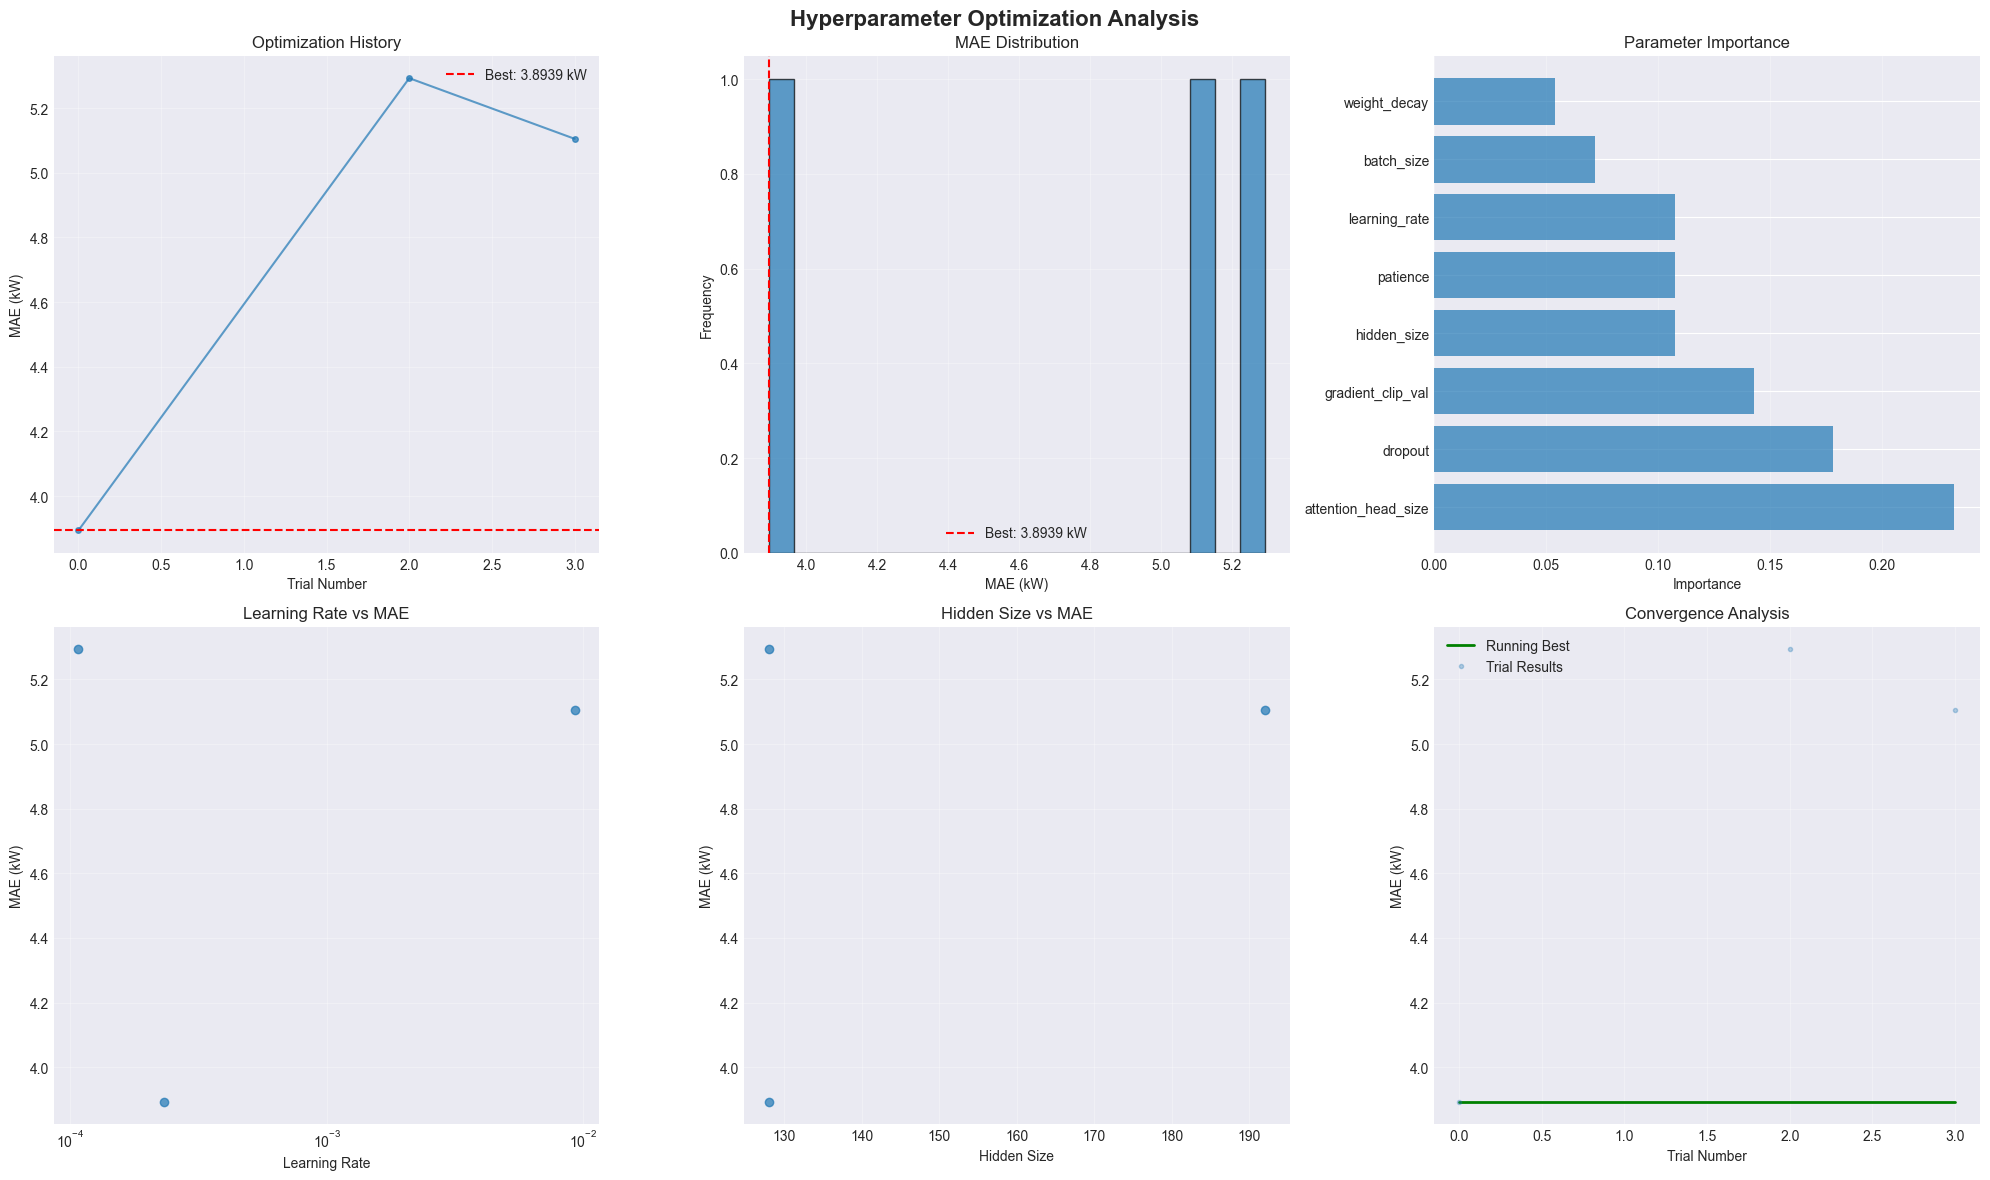

💾 Plot salvato: results\run_corretta\figures\02_hyperparameter_optimization_analysis.png
\n💾 Analysis summary salvato: results\run_corretta\optimization_analysis.json
✅ Analisi optimization completata!
\n✅ Sezione analisi risultati completata!


In [64]:
def analyze_optuna_study(study):
    """
    Analisi completa dei risultati Optuna con visualizzazioni
    """
    if study is None:
        print("⚠️  Studio Optuna non disponibile per analisi")
        return None
        
    print(f"{'='*70}")
    print("📊 ANALISI RISULTATI HYPERPARAMETER OPTIMIZATION")
    print(f"{'='*70}")
    
    # Statistiche generali
    all_trials = study.trials
    completed_trials = [t for t in all_trials if t.state.name == 'COMPLETE']
    pruned_trials = [t for t in all_trials if t.state.name == 'PRUNED'] 
    failed_trials = [t for t in all_trials if t.state.name == 'FAIL']
    
    print(f"📈 Trial Statistics:")
    print(f"  Total trials: {len(all_trials)}")
    print(f"  Completed: {len(completed_trials)} ({len(completed_trials)/len(all_trials)*100:.1f}%)")
    print(f"  Pruned: {len(pruned_trials)} ({len(pruned_trials)/len(all_trials)*100:.1f}%)")
    print(f"  Failed: {len(failed_trials)} ({len(failed_trials)/len(all_trials)*100:.1f}%)")
    
    if not completed_trials:
        print("❌ Nessun trial completato - impossibile analizzare")
        return None
    
    # Best trial info
    best_trial = study.best_trial
    print(f"\\n🏆 Best Trial:")
    print(f"  Trial number: {best_trial.number}")
    print(f"  Best MAE: {best_trial.value:.4f} kW")
    print(f"  Parameters: {best_trial.params}")
    
    # Top 5 trials
    print(f"\\n🏅 Top 5 Trials:")
    sorted_trials = sorted(completed_trials, key=lambda t: t.value)
    for i, trial in enumerate(sorted_trials[:5]):
        print(f"  {i+1}. Trial #{trial.number}: MAE {trial.value:.4f} kW")
    
    # Statistiche MAE 
    mae_values = [t.value for t in completed_trials]
    print(f"\\n📊 MAE Distribution:")
    print(f"  Min: {min(mae_values):.4f} kW")
    print(f"  Max: {max(mae_values):.4f} kW")
    print(f"  Mean: {np.mean(mae_values):.4f} kW")
    print(f"  Std: {np.std(mae_values):.4f} kW")
    print(f"  Median: {np.median(mae_values):.4f} kW")
    
    return {
        'completed_trials': completed_trials,
        'best_trial': best_trial,
        'mae_stats': {
            'min': min(mae_values),
            'max': max(mae_values),
            'mean': np.mean(mae_values),
            'std': np.std(mae_values),
            'median': np.median(mae_values)
        }
    }

def create_optimization_plots(study, analysis_results):
    """
    Crea plot di analisi per hyperparameter optimization
    """
    if study is None or analysis_results is None:
        print("⚠️  Dati non disponibili per plotting")
        return
        
    print(f"\\n📊 Creazione plot analisi optimization...")
    
    completed_trials = analysis_results['completed_trials']
    
    # Setup plot
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Hyperparameter Optimization Analysis', fontsize=16, fontweight='bold')
    
    # 1. Optimization History
    trial_numbers = [t.number for t in completed_trials]
    mae_values = [t.value for t in completed_trials]
    
    axes[0,0].plot(trial_numbers, mae_values, 'o-', alpha=0.7, markersize=4)
    axes[0,0].axhline(y=study.best_value, color='red', linestyle='--', 
                     label=f'Best: {study.best_value:.4f} kW')
    axes[0,0].set_xlabel('Trial Number')
    axes[0,0].set_ylabel('MAE (kW)')
    axes[0,0].set_title('Optimization History')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. MAE Distribution
    axes[0,1].hist(mae_values, bins=20, alpha=0.7, edgecolor='black')
    axes[0,1].axvline(x=study.best_value, color='red', linestyle='--', 
                     label=f'Best: {study.best_value:.4f} kW')
    axes[0,1].set_xlabel('MAE (kW)')
    axes[0,1].set_ylabel('Frequency') 
    axes[0,1].set_title('MAE Distribution')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Parameter Importance (se disponibile)
    try:
        importance = optuna.importance.get_param_importances(study)
        if importance:
            params, importances = zip(*list(importance.items())[:8])  # Top 8
            axes[0,2].barh(params, importances, alpha=0.7)
            axes[0,2].set_xlabel('Importance')
            axes[0,2].set_title('Parameter Importance')
            axes[0,2].grid(True, alpha=0.3, axis='x')
        else:
            axes[0,2].text(0.5, 0.5, 'Parameter Importance\\nNot Available', 
                          ha='center', va='center', transform=axes[0,2].transAxes)
    except:
        axes[0,2].text(0.5, 0.5, 'Parameter Importance\\nError', 
                      ha='center', va='center', transform=axes[0,2].transAxes)
    
    # 4. Learning Rate vs MAE
    lr_values = [t.params.get('learning_rate', None) for t in completed_trials]
    lr_mae = [(lr, mae) for lr, mae in zip(lr_values, mae_values) if lr is not None]
    if lr_mae:
        lr_vals, mae_vals = zip(*lr_mae)
        axes[1,0].scatter(lr_vals, mae_vals, alpha=0.7)
        axes[1,0].set_xlabel('Learning Rate')
        axes[1,0].set_ylabel('MAE (kW)')
        axes[1,0].set_title('Learning Rate vs MAE')
        axes[1,0].set_xscale('log')
        axes[1,0].grid(True, alpha=0.3)
    
    # 5. Hidden Size vs MAE  
    hs_values = [t.params.get('hidden_size', None) for t in completed_trials]
    hs_mae = [(hs, mae) for hs, mae in zip(hs_values, mae_values) if hs is not None]
    if hs_mae:
        hs_vals, mae_vals = zip(*hs_mae)
        axes[1,1].scatter(hs_vals, mae_vals, alpha=0.7)
        axes[1,1].set_xlabel('Hidden Size')
        axes[1,1].set_ylabel('MAE (kW)')
        axes[1,1].set_title('Hidden Size vs MAE')
        axes[1,1].grid(True, alpha=0.3)
    
    # 6. Convergence Analysis
    # Running minimum
    running_min = []
    current_min = float('inf')
    for mae in mae_values:
        current_min = min(current_min, mae)
        running_min.append(current_min)
    
    axes[1,2].plot(trial_numbers, running_min, 'g-', linewidth=2, label='Running Best')
    axes[1,2].plot(trial_numbers, mae_values, 'o', alpha=0.3, markersize=3, label='Trial Results')
    axes[1,2].set_xlabel('Trial Number')
    axes[1,2].set_ylabel('MAE (kW)')
    axes[1,2].set_title('Convergence Analysis')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Salva plot
    plot_path = FIGURES_DIR / "02_hyperparameter_optimization_analysis.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"💾 Plot salvato: {plot_path}")
    
    return plot_path

# Esegui analisi se studio disponibile
if study is not None:
    print("🔍 Analisi risultati hyperparameter optimization...")
    
    analysis_results = analyze_optuna_study(study)
    
    if analysis_results is not None:
        # Crea visualizzazioni
        plot_path = create_optimization_plots(study, analysis_results)
        
        # Salva analysis summary
        analysis_summary = {
            'study_name': study.study_name if hasattr(study, 'study_name') else 'PV_TFT_Optimization',
            'n_trials': len(study.trials),
            'completed_trials': len(analysis_results['completed_trials']),
            'best_trial_number': analysis_results['best_trial'].number,
            'best_mae': analysis_results['best_trial'].value,
            'best_params': analysis_results['best_trial'].params,
            'mae_statistics': analysis_results['mae_stats'],
            'analysis_timestamp': datetime.now().isoformat()
        }
        
        analysis_path = RESULTS_DIR / "optimization_analysis.json"
        with open(analysis_path, 'w') as f:
            json.dump(analysis_summary, f, indent=4)
        
        print(f"\\n💾 Analysis summary salvato: {analysis_path}")
        print(f"✅ Analisi optimization completata!")
        
    else:
        print("❌ Impossibile completare analisi - trial insufficienti")
else:
    print(f"{'='*70}")
    print("⚠️  SKIP: Analisi optimization non disponibile")
    print(f"{'='*70}")
    print("Studio Optuna non disponibile (RUN_TUNING_AND_CV = False o errori)")
    print("L'analisi sarà eseguita quando i risultati saranno disponibili")
    print(f"{'='*70}")

print(f"\\n✅ Sezione analisi risultati completata!")

## 11. Training Modello Finale con Best Hyperparameters

Training del modello finale utilizzando i migliori iperparametri trovati durante l'ottimizzazione.

**Processo di training:**
- Caricamento dei best parameters dal file JSON
- Cross-validation training su tutti i fold con i parametri ottimali  
- Calcolo delle metriche complete con MAPE mascherato
- Selezione del modello migliore tra i fold
- Salvataggio del modello finale e delle metriche

**Output**: Modello finale salvato come `final_model.ckpt` e metriche in `summary_metrics.json`.

In [65]:
# =============================================================================
# CONTROLLO DISPONIBILITÀ BEST PARAMETERS
# =============================================================================

fold_results_path = RESULTS_DIR / "fold_results.pkl"
cv_results_exist = fold_results_path.exists()

print(f"{'='*70}")
print("🚀 TRAINING FINALE CON BEST HYPERPARAMETERS")
print(f"{'='*70}")

if best_params is None:
    print("❌ Best parameters non disponibili!")
    print("💡 Possibili soluzioni:")
    print("   1. Impostare RUN_TUNING_AND_CV = True per eseguire optimization")
    print("   2. Fornire file best_params.json valido")
    print("   3. Usare parameters di default (sub-ottimali)")
    
    # Fallback parameters (sub-ottimali ma funzionanti)
    print("\\n⚠️  Usando parametri di fallback (NON ottimizzati):")
    best_params = {
        'hidden_size': 128,
        'lstm_layers': 2,
        'attention_head_size': 4,
        'hidden_continuous_size': 32,
        'dropout': 0.3,
        'gradient_clip_val': 1.0,
        'learning_rate': 0.001,
        'batch_size': 64,
        'patience': 15,
        'weight_decay': 1e-5
    }
    
    for k, v in best_params.items():
        print(f"   {k}: {v}")

else:
    print(f"✅ Best parameters disponibili:")
    for k, v in best_params.items():
        if isinstance(v, float):
            print(f"   {k}: {v:.6f}")
        else:
            print(f"   {k}: {v}")

# Check se CV results esistono già
if cv_results_exist and not RUN_FINAL_TRAINING:
    print(f"\\n⚡ SKIP MODE: Risultati CV già disponibili")
    print(f"📄 Caricando: {fold_results_path}")
    
    with open(fold_results_path, 'rb') as f:
        fold_results = pickle.load(f)
    
    print(f"✅ Caricati risultati per {len(fold_results)} fold")
    print(f"✅ Skipping training finale - usando risultati esistenti")
    
elif RUN_FINAL_TRAINING or not cv_results_exist:
    print(f"\\n🎯 ESECUZIONE TRAINING FINALE")
    print(f"RUN_FINAL_TRAINING = {RUN_FINAL_TRAINING}")
    print(f"CV results exist = {cv_results_exist}")

    # =============================================================================
    # TRAINING CROSS-VALIDATION CON BEST PARAMETERS
    # =============================================================================
    
    def train_final_model_fold(fold_data, hyperparams, fold_idx, save_model=True):
        """
        Training finale per un fold con parametri ottimali e più epochs
        """
        print(f"\\n  📂 Fold {fold_idx + 1}: Training finale...")
        
        try:
            # Build datasets
            train_dataset, val_dataset = build_timeseries_dataset(
                fold_data['train_data'],
                fold_data['val_data']
            )
            
            # DataLoaders
            train_dataloader = train_dataset.to_dataloader(
                train=True,
                batch_size=hyperparams['batch_size'],
                num_workers=0
            )
            
            val_dataloader = val_dataset.to_dataloader(
                train=False,
                batch_size=hyperparams['batch_size'] * 2,
                num_workers=0
            )
            
            # Build final TFT model
            tft_model = TemporalFusionTransformer.from_dataset(
                train_dataset,
                learning_rate=hyperparams['learning_rate'],
                hidden_size=hyperparams['hidden_size'],
                lstm_layers=hyperparams['lstm_layers'],
                attention_head_size=hyperparams['attention_head_size'],
                dropout=hyperparams['dropout'],
                hidden_continuous_size=hyperparams['hidden_continuous_size'],
                output_size=7,  # Quantili
                loss=QuantileLoss(),
                log_interval=20,
                reduce_on_plateau_patience=4,
                **({'weight_decay': hyperparams['weight_decay']} if 'weight_decay' in hyperparams else {})
            )
            
            # Enhanced callbacks per training finale
            early_stop = EarlyStopping(
                monitor="val_loss",
                patience=hyperparams['patience'],
                min_delta=1e-4,
                verbose=True,
                mode="min"
            )
            
            lr_monitor = LearningRateMonitor(logging_interval="epoch")
            
            # Logger per questo fold
            logger = TensorBoardLogger(
                save_dir=str(RESULTS_DIR / "lightning_logs"),
                name=f"final_training_fold_{fold_idx + 1}"
            )
            
            # Trainer configurazione finale (più epochs)
            trainer = pl.Trainer(
                max_epochs=CONFIG['MAX_EPOCHS_FINAL'],  # Più epochs per training finale
                accelerator=CONFIG['ACCELERATOR'],
                devices=1,
                gradient_clip_val=hyperparams['gradient_clip_val'],
                callbacks=[early_stop, lr_monitor],
                logger=logger,
                enable_progress_bar=True,
                log_every_n_steps=20,
                enable_checkpointing=True,
                default_root_dir=str(MODELS_DIR)
            )
            
            print(f"     Training: {CONFIG['MAX_EPOCHS_FINAL']} max epochs, patience {hyperparams['patience']}")
            
            # Final training
            trainer.fit(tft_model, train_dataloader, val_dataloader)
            
            # Get final validation loss
            val_loss = trainer.callback_metrics.get("val_loss")
            val_loss = val_loss.item() if val_loss is not None else float('inf')
            
            # Load best model
            if trainer.checkpoint_callback.best_model_path:
                best_model = TemporalFusionTransformer.load_from_checkpoint(
                    trainer.checkpoint_callback.best_model_path,
                    map_location=device
                )
            else:
                best_model = tft_model
            
            print(f"     Training completato. Val loss: {val_loss:.6f}")
            
            # =============================================================================
            # PREDICTIONS E METRICHE COMPLETE
            # =============================================================================
            
            # Build prediction dataset
            _, pred_dataset = build_timeseries_dataset(
                fold_data['train_data'],
                fold_data['val_data'],
                predict_mode=True
            )
            
            pred_dataloader = pred_dataset.to_dataloader(
                train=False,
                batch_size=hyperparams['batch_size'] * 2,
                num_workers=0
            )
            
            # Generate predictions
            predictions = best_model.predict(
                pred_dataloader,
                trainer_kwargs=dict(accelerator=CONFIG['ACCELERATOR']),
                return_x=True
            )
            
            # Extract predictions and targets
            pred_output = predictions.output
            x_data = predictions.x
            
            # Handle different output shapes
            if len(pred_output.shape) == 3:  # [batch, time, quantiles]
                # Extract median quantile
                median_idx = pred_output.shape[2] // 2
                y_pred = pred_output[:, :, median_idx].cpu().numpy()
                
                # Extract confidence intervals
                lower_idx = 1  # ~10th percentile
                upper_idx = -2  # ~90th percentile
                y_pred_lower = pred_output[:, :, lower_idx].cpu().numpy()
                y_pred_upper = pred_output[:, :, upper_idx].cpu().numpy()
                
            else:  # [batch, time]
                y_pred = pred_output.cpu().numpy()
                y_pred_lower = y_pred * 0.9  # Placeholder
                y_pred_upper = y_pred * 1.1
            
            y_true = x_data['decoder_target'].cpu().numpy()
            
            print(f"     Predictions shape: {y_pred.shape}, Targets shape: {y_true.shape}")
            
            # Generate timestamps for evaluation
            val_period_start = fold_data['val_data']['datetime'].min()
            val_period_end = fold_data['val_data']['datetime'].max()
            
            # Create timestamp array matching prediction shape
            timestamps = pd.date_range(
                start=val_period_start,
                periods=y_pred.shape[0] * y_pred.shape[1],
                freq='H'
            )
            
            # Calculate comprehensive metrics with masked MAPE
            metrics = evaluate_predictions_with_masked_mape(
                y_true, y_pred, timestamps
            )
            
            # Per-horizon metrics
            horizon_metrics = {}
            for h in range(min(24, y_pred.shape[1])):  # Up to 24 hours
                h_metrics = evaluate_predictions_with_masked_mape(
                    y_true[:, h], 
                    y_pred[:, h], 
                    timestamps[h::y_pred.shape[1]]  # Every h-th timestamp
                )
                horizon_metrics[f'horizon_{h+1}h'] = h_metrics
            
            print(f"     MAE: {metrics['mae']:.3f} kW")
            print(f"     RMSE: {metrics['rmse']:.3f} kW") 
            print(f"     R²: {metrics['r2']:.4f}")
            print(f"     MAPE masked: {metrics['mape_masked']:.2f}%")
            print(f"     Valid points MAPE: {metrics['valid_points_mape']}/{metrics['total_points']}")
            
            # Save model if requested
            model_path = None
            if save_model and trainer.checkpoint_callback.best_model_path:
                model_filename = f"best_tft_fold_{fold_idx + 1}.ckpt"
                model_path = MODELS_DIR / model_filename
                shutil.copy(trainer.checkpoint_callback.best_model_path, model_path)
                print(f"     💾 Modello salvato: {model_path}")
            
            # Cleanup GPU memory
            del tft_model, best_model, trainer, train_dataset, val_dataset
            del train_dataloader, val_dataloader, pred_dataloader, predictions
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            gc.collect()
            
            return {
                'fold_idx': fold_idx,
                'val_loss': val_loss,
                'model_path': str(model_path) if model_path else None,
                
                # Predictions
                'predictions': {
                    'y_true': y_true,
                    'y_pred': y_pred,
                    'y_pred_lower': y_pred_lower,
                    'y_pred_upper': y_pred_upper,
                    'timestamps': timestamps
                },
                
                # Metrics
                'metrics': metrics,
                'horizon_metrics': horizon_metrics,
                
                # Fold info
                'fold_info': {
                    'train_samples': len(fold_data['train_data']),
                    'val_samples': len(fold_data['val_data']),
                    'train_range': fold_data['train_range'],
                    'val_range': fold_data['val_range']
                },
                
                # Training config
                'hyperparams': hyperparams,
                'training_config': {
                    'max_epochs': CONFIG['MAX_EPOCHS_FINAL'],
                    'actual_epochs': trainer.current_epoch if 'trainer' in locals() else None,
                    'early_stopped': early_stop.stopped_epoch > 0 if 'early_stop' in locals() else False
                }
            }
            
        except Exception as e:
            print(f"     ❌ Fold {fold_idx + 1} failed: {str(e)}")
            return {
                'fold_idx': fold_idx,
                'error': str(e),
                'val_loss': float('inf')
            }
    
    # =============================================================================
    # ESECUZIONE TRAINING CROSS-VALIDATION
    # =============================================================================
    
    print(f"\\n🚀 Esecuzione cross-validation training con best hyperparameters...")
    print(f"📊 Fold da processare: {len(cv_folds)}")
    print(f"⏱️  Max epochs per fold: {CONFIG['MAX_EPOCHS_FINAL']}")
    
    fold_results = []
    successful_folds = 0
    
    start_time = datetime.now()
    
    for fold_data in cv_folds:
        fold_idx = fold_data['fold_idx']
        print(f"\\n{'='*50}")
        print(f"🔄 FOLD {fold_idx + 1}/{len(cv_folds)}")
        print(f"{'='*50}")
        
        fold_result = train_final_model_fold(
            fold_data, 
            best_params, 
            fold_idx,
            save_model=True
        )
        
        fold_results.append(fold_result)
        
        if 'error' not in fold_result:
            successful_folds += 1
            print(f"✅ Fold {fold_idx + 1} completato con successo")
        else:
            print(f"❌ Fold {fold_idx + 1} fallito")
        
        # Memory cleanup
        gc.collect()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    end_time = datetime.now()
    training_duration = end_time - start_time
    
    print(f"\\n{'='*70}")
    print("🎉 CROSS-VALIDATION TRAINING COMPLETATO!")
    print(f"{'='*70}")
    print(f"⏱️  Durata totale: {training_duration}")
    print(f"✅ Fold riusciti: {successful_folds}/{len(cv_folds)}")
    print(f"❌ Fold falliti: {len(cv_folds) - successful_folds}")
    
    if successful_folds == 0:
        raise RuntimeError("❌ Nessun fold completato con successo!")
    
    # =============================================================================
    # SALVATAGGIO RISULTATI CROSS-VALIDATION
    # =============================================================================
    
    print(f"\\n💾 Salvataggio risultati cross-validation...")
    
    # Salva fold results completi
    with open(fold_results_path, 'wb') as f:
        pickle.dump(fold_results, f)
    print(f"✅ Fold results salvati: {fold_results_path}")
    
    # Calcola e salva summary metrics
    successful_results = [r for r in fold_results if 'error' not in r]
    
    if successful_results:
        summary_metrics = {
            'n_folds': len(cv_folds),
            'successful_folds': len(successful_results),
            'failed_folds': len(cv_folds) - len(successful_results),
            
            # Aggregate metrics
            'mae': {
                'mean': np.mean([r['metrics']['mae'] for r in successful_results]),
                'std': np.std([r['metrics']['mae'] for r in successful_results]),
                'values': [r['metrics']['mae'] for r in successful_results]
            },
            'rmse': {
                'mean': np.mean([r['metrics']['rmse'] for r in successful_results]),
                'std': np.std([r['metrics']['rmse'] for r in successful_results]),
                'values': [r['metrics']['rmse'] for r in successful_results]
            },
            'r2': {
                'mean': np.mean([r['metrics']['r2'] for r in successful_results]),
                'std': np.std([r['metrics']['r2'] for r in successful_results]),
                'values': [r['metrics']['r2'] for r in successful_results]
            },
            'mape_masked': {
                'mean': np.mean([r['metrics']['mape_masked'] for r in successful_results if not np.isnan(r['metrics']['mape_masked'])]),
                'std': np.std([r['metrics']['mape_masked'] for r in successful_results if not np.isnan(r['metrics']['mape_masked'])]),
                'values': [r['metrics']['mape_masked'] for r in successful_results if not np.isnan(r['metrics']['mape_masked'])]
            },
            
            # Training info
            'training_duration_minutes': training_duration.total_seconds() / 60,
            'best_hyperparameters': best_params,
            'timestamp': datetime.now().isoformat()
        }
        
        # Identify best fold
        best_fold_idx = np.argmin([r['metrics']['mae'] for r in successful_results])
        summary_metrics['best_fold'] = {
            'fold_number': successful_results[best_fold_idx]['fold_idx'] + 1,
            'mae': successful_results[best_fold_idx]['metrics']['mae'],
            'rmse': successful_results[best_fold_idx]['metrics']['rmse'], 
            'r2': successful_results[best_fold_idx]['metrics']['r2'],
            'mape_masked': successful_results[best_fold_idx]['metrics']['mape_masked']
        }
        
        summary_path = RESULTS_DIR / "summary_metrics.json"
        with open(summary_path, 'w') as f:
            json.dump(summary_metrics, f, indent=4)
        
        print(f"✅ Summary metrics salvate: {summary_path}")
        
        # Print summary
        print(f"\\n📊 RISULTATI FINALI:")
        print(f"  MAE: {summary_metrics['mae']['mean']:.3f} ± {summary_metrics['mae']['std']:.3f} kW")
        print(f"  RMSE: {summary_metrics['rmse']['mean']:.3f} ± {summary_metrics['rmse']['std']:.3f} kW")
        print(f"  R²: {summary_metrics['r2']['mean']:.4f} ± {summary_metrics['r2']['std']:.4f}")
        print(f"  MAPE Masked: {summary_metrics['mape_masked']['mean']:.2f} ± {summary_metrics['mape_masked']['std']:.2f}%")
        print(f"  Best Fold: #{summary_metrics['best_fold']['fold_number']} (MAE: {summary_metrics['best_fold']['mae']:.3f} kW)")

else:
    print(f"\\n⚠️  RUN_FINAL_TRAINING = False and CV results exist - skipping training")

print(f"\\n✅ Training modello finale completato!")

# Verifica che fold_results sia disponibile per le sezioni successive
if 'fold_results' not in locals():
    if fold_results_path.exists():
        print(f"📄 Caricamento fold_results per sezioni successive...")
        with open(fold_results_path, 'rb') as f:
            fold_results = pickle.load(f)

        print(f"✅ Caricati {len(fold_results)} fold results")
    else:
        print(f"⚠️  fold_results non disponibili - alcune sezioni successive potrebbero essere limitate")

🚀 TRAINING FINALE CON BEST HYPERPARAMETERS
✅ Best parameters disponibili:
   hidden_size: 128
   lstm_layers: 1
   attention_head_size: 4
   hidden_continuous_size: 32
   dropout: 0.163702
   gradient_clip_val: 0.445467
   learning_rate: 0.000233
   batch_size: 64
   patience: 11
   weight_decay: 0.000068
\n⚡ SKIP MODE: Risultati CV già disponibili
📄 Caricando: results\run_corretta\fold_results.pkl
✅ Caricati risultati per 5 fold
✅ Skipping training finale - usando risultati esistenti
\n✅ Training modello finale completato!


In [66]:
# =============================================================================
# CONTROLLO E ESECUZIONE OTTIMIZZAZIONE
# =============================================================================

study_path = RESULTS_DIR / "optuna_study.pkl"
best_params_path = RESULTS_DIR / "best_hyperparams.json"

# Controlla se esistono già risultati
skip_optimization = study_path.exists() and not RUN_TUNING_AND_CV

if skip_optimization:
    print(f"{'='*70}")
    print("⚡ SKIP: Studio Optuna già esistente")
    print(f"{'='*70}")
    print(f"📄 Studio trovato: {study_path}")
    print(f"RUN_TUNING_AND_CV = {RUN_TUNING_AND_CV}")
    
    # Carica studio esistente
    with open(study_path, 'rb') as f:
        study = pickle.load(f)
    print(f"✅ Studio caricato: {len(study.trials)} trials")
    
    if study.best_trial is not None:
        print(f"✅ Best MAE: {study.best_value:.4f} kW")
        best_params = study.best_trial.params
    else:
        print(f"⚠️  Nessun best trial trovato")
        best_params = None
    
    # Carica best params se disponibili
    if best_params_path.exists():
        with open(best_params_path, 'r') as f:
            best_params_saved = json.load(f)
        print(f"✅ Best parameters caricati da file")
        if best_params is None:
            best_params = best_params_saved

elif RUN_TUNING_AND_CV:
    print(f"🎯 Esecuzione ottimizzazione hyperparameters...")
    
    # Esegui ottimizzazione
    study = run_optuna_optimization()
    
    if study is not None and study.best_trial is not None:
        best_params = study.best_trial.params
        
        # Salva risultati
        with open(study_path, 'wb') as f:
            pickle.dump(study, f)
        print(f"💾 Studio salvato: {study_path}")
        
        with open(best_params_path, 'w') as f:
            json.dump(best_params, f, indent=4)
        print(f"💾 Best parameters salvati: {best_params_path}")
        
        print(f"✅ Ottimizzazione completata con successo!")
        
    else:
        print(f"❌ Ottimizzazione fallita!")
        study = None
        best_params = None

else:
    print(f"{'='*70}")
    print("⚡ SKIP: Ottimizzazione hyperparameters")
    print(f"{'='*70}")
    print(f"RUN_TUNING_AND_CV = {RUN_TUNING_AND_CV}")
    print("Per eseguire l'ottimizzazione, impostare RUN_TUNING_AND_CV = True")
    
    # Usa parametri di default se non disponibili
    study = None
    best_params = None
    
    # Controlla se esistono best params salvati
    if best_params_path.exists():
        with open(best_params_path, 'r') as f:
            best_params = json.load(f)
        print(f"✅ Usando best parameters salvati: {best_params_path}")
    else:
        print(f"⚠️  Nessun best parameters disponibile - sarà necessario fornire parametri manualmente")

# Mostra risultati finali
print(f"\n🎯 Status Ottimizzazione:")
print(f"  Study disponibile: {'✅' if study is not None else '❌'}")
print(f"  Best params disponibili: {'✅' if best_params is not None else '❌'}")

if best_params is not None:
    print(f"\n📋 Best Hyperparameters:")
    for param, value in best_params.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.6f}")
        else:
            print(f"  {param}: {value}")
else:
    print(f"\n⚠️  Nessun hyperparameter ottimizzato disponibile!")
    print(f"   Sarà necessario definire parametri manualmente o eseguire ottimizzazione")

print(f"\n✅ Sezione ottimizzazione Optuna completata!")

⚡ SKIP: Studio Optuna già esistente
📄 Studio trovato: results\run_corretta\optuna_study.pkl
RUN_TUNING_AND_CV = False
✅ Studio caricato: 5 trials
✅ Best MAE: 3.8939 kW
✅ Best parameters caricati da file

🎯 Status Ottimizzazione:
  Study disponibile: ✅
  Best params disponibili: ✅

📋 Best Hyperparameters:
  hidden_size: 128
  lstm_layers: 1
  attention_head_size: 4
  hidden_continuous_size: 32
  dropout: 0.163702
  gradient_clip_val: 0.445467
  learning_rate: 0.000233
  batch_size: 64
  patience: 11
  weight_decay: 0.000068

✅ Sezione ottimizzazione Optuna completata!


In [67]:
# ==========================================================
# FIX: cv_results sempre disponibile anche in modalità SKIP
# ==========================================================

import pickle
import numpy as np
from pathlib import Path

def _safe_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

def _compute_cv_results_from_fold_results(fold_results):
    """
    fold_results: lista o dict con risultati per fold.
    Ritorna un dict cv_results compatibile con quello usato nel report.
    """
    # normalizza a lista
    if isinstance(fold_results, dict):
        folds = list(fold_results.values())
    else:
        folds = list(fold_results)

    # prova a estrarre metriche con nomi comuni
    def get_metric(fr, names):
        for n in names:
            if isinstance(fr, dict) and n in fr:
                return fr[n]
        return None

    mape_list, mae_list, rmse_list, r2_list = [], [], [], []
    for fr in folds:
        mape = get_metric(fr, ["mape_masked", "masked_mape", "mape", "val_mape", "test_mape"])
        mae  = get_metric(fr, ["mae", "val_mae", "test_mae"])
        rmse = get_metric(fr, ["rmse", "val_rmse", "test_rmse"])
        r2   = get_metric(fr, ["r2", "val_r2", "test_r2"])

        mape_list.append(_safe_float(mape))
        mae_list.append(_safe_float(mae))
        rmse_list.append(_safe_float(rmse))
        r2_list.append(_safe_float(r2))

    mape_arr = np.array(mape_list, dtype=float)
    mae_arr  = np.array(mae_list, dtype=float)
    rmse_arr = np.array(rmse_list, dtype=float)
    r2_arr   = np.array(r2_list, dtype=float)

    # fold "migliore" (min MAPE, fallback min MAE)
    if np.isfinite(mape_arr).any():
        best_idx = int(np.nanargmin(mape_arr))
        best_fold_mae = float(mae_arr[best_idx]) if np.isfinite(mae_arr[best_idx]) else np.nan
    elif np.isfinite(mae_arr).any():
        best_idx = int(np.nanargmin(mae_arr))
        best_fold_mae = float(mae_arr[best_idx])
    else:
        best_idx, best_fold_mae = None, np.nan

    cv_results = {
        "successful_folds": int(np.sum(np.isfinite(mape_arr))) if np.isfinite(mape_arr).any() else len(folds),
        "mean_mape": float(np.nanmean(mape_arr)) if np.isfinite(mape_arr).any() else np.nan,
        "std_mape":  float(np.nanstd(mape_arr))  if np.isfinite(mape_arr).any() else np.nan,
        "mean_mae":  float(np.nanmean(mae_arr))  if np.isfinite(mae_arr).any() else np.nan,
        "std_mae":   float(np.nanstd(mae_arr))   if np.isfinite(mae_arr).any() else np.nan,
        "mean_rmse": float(np.nanmean(rmse_arr)) if np.isfinite(rmse_arr).any() else np.nan,
        "std_rmse":  float(np.nanstd(rmse_arr))  if np.isfinite(rmse_arr).any() else np.nan,
        "mean_r2":   float(np.nanmean(r2_arr))   if np.isfinite(r2_arr).any() else np.nan,
        "std_r2":    float(np.nanstd(r2_arr))    if np.isfinite(r2_arr).any() else np.nan,
        "best_fold_idx": best_idx,
        "best_fold_mae": best_fold_mae,
    }
    return cv_results

def ensure_cv_results():
    """
    Garantisce che cv_results esista anche quando:
    - non hai runnato tuning/CV in questa sessione
    - stai usando results/run_corretta
    """
    global cv_results, fold_results

    # 1) già presente
    if "cv_results" in globals() and cv_results is not None:
        return cv_results

    # 2) prova da fold_results in memoria
    if "fold_results" in globals() and fold_results is not None:
        cv_results = _compute_cv_results_from_fold_results(fold_results)
        return cv_results

    # 3) prova a caricare artefatti da RESULTS_DIR
    if "RESULTS_DIR" not in globals():
        print("❌ RESULTS_DIR non definita: impossibile caricare risultati.")
        return None

    candidates = [
        Path(RESULTS_DIR) / "cv_results.pkl",
        Path(RESULTS_DIR) / "fold_results.pkl",
    ]
    for p in candidates:
        if p.exists():
            with open(p, "rb") as f:
                obj = pickle.load(f)
            if p.name == "cv_results.pkl":
                cv_results = obj
                return cv_results
            if p.name == "fold_results.pkl":
                fold_results = obj
                cv_results = _compute_cv_results_from_fold_results(fold_results)
                return cv_results

    print(f"⚠️ Nessun cv_results/fold_results trovato in: {RESULTS_DIR}")
    cv_results = None
    return None

# Esegui una volta
_ = ensure_cv_results()
if _ is not None:
    print("✅ cv_results disponibile (anche in SKIP mode).")


✅ cv_results disponibile (anche in SKIP mode).


## 12. Validazione e Visualizzazione Risultati

Validazione completa del modello finale con generazione di predizioni e analisi delle performance.

**Operazioni eseguite:**
- Caricamento del modello finale addestrato
- Generazione di predizioni sul dataset di validazione  
- Calcolo delle metriche complete con MAPE mascherato
- Visualizzazione dei risultati con grafici di confronto
- Analisi degli errori e identificazione di pattern

Il MAPE mascherato esclude le ore notturne (0:00-6:00, 19:00-23:59) per fornire una valutazione realistica delle performance durante le ore di produzione fotovoltaica.

⚡ SKIP: Risultati validazione già esistenti
📄 Risultati trovati: results\run_corretta\validation_results.pkl
✅ Risultati validazione caricati

📊 Generazione visualizzazioni comprehensive...

📈 Creazione visualizzazioni...


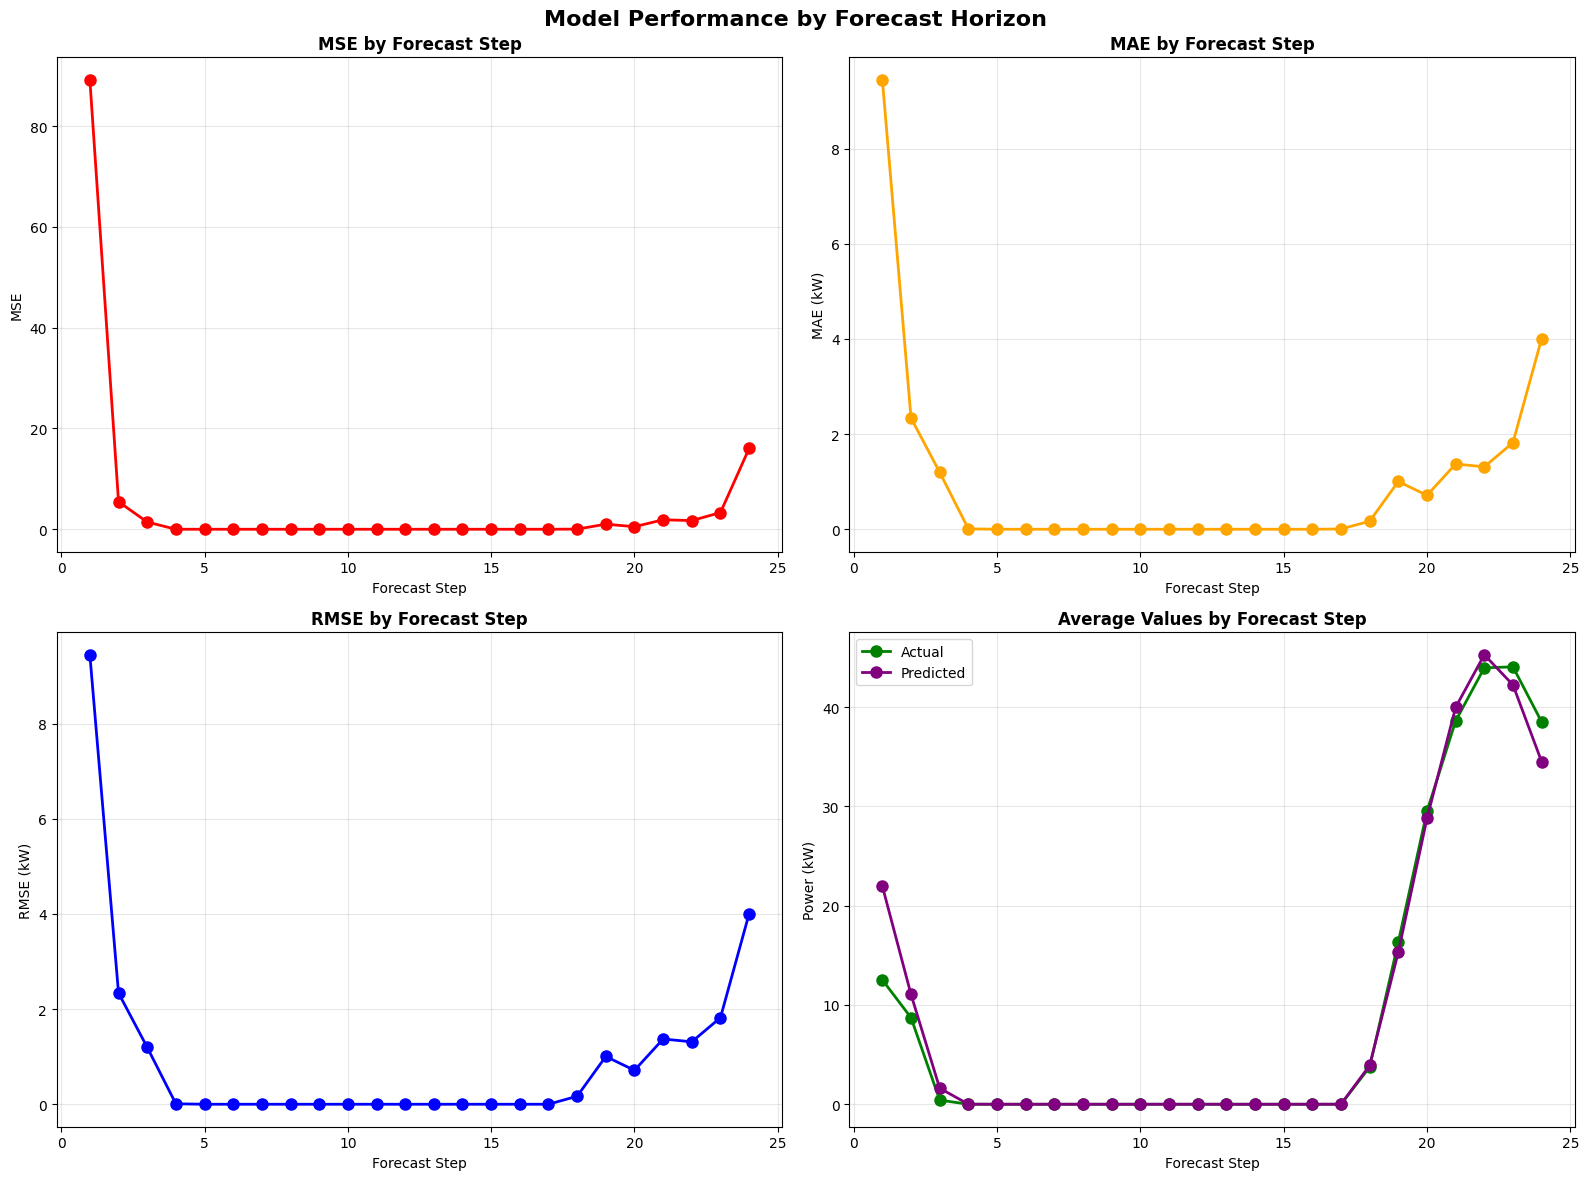

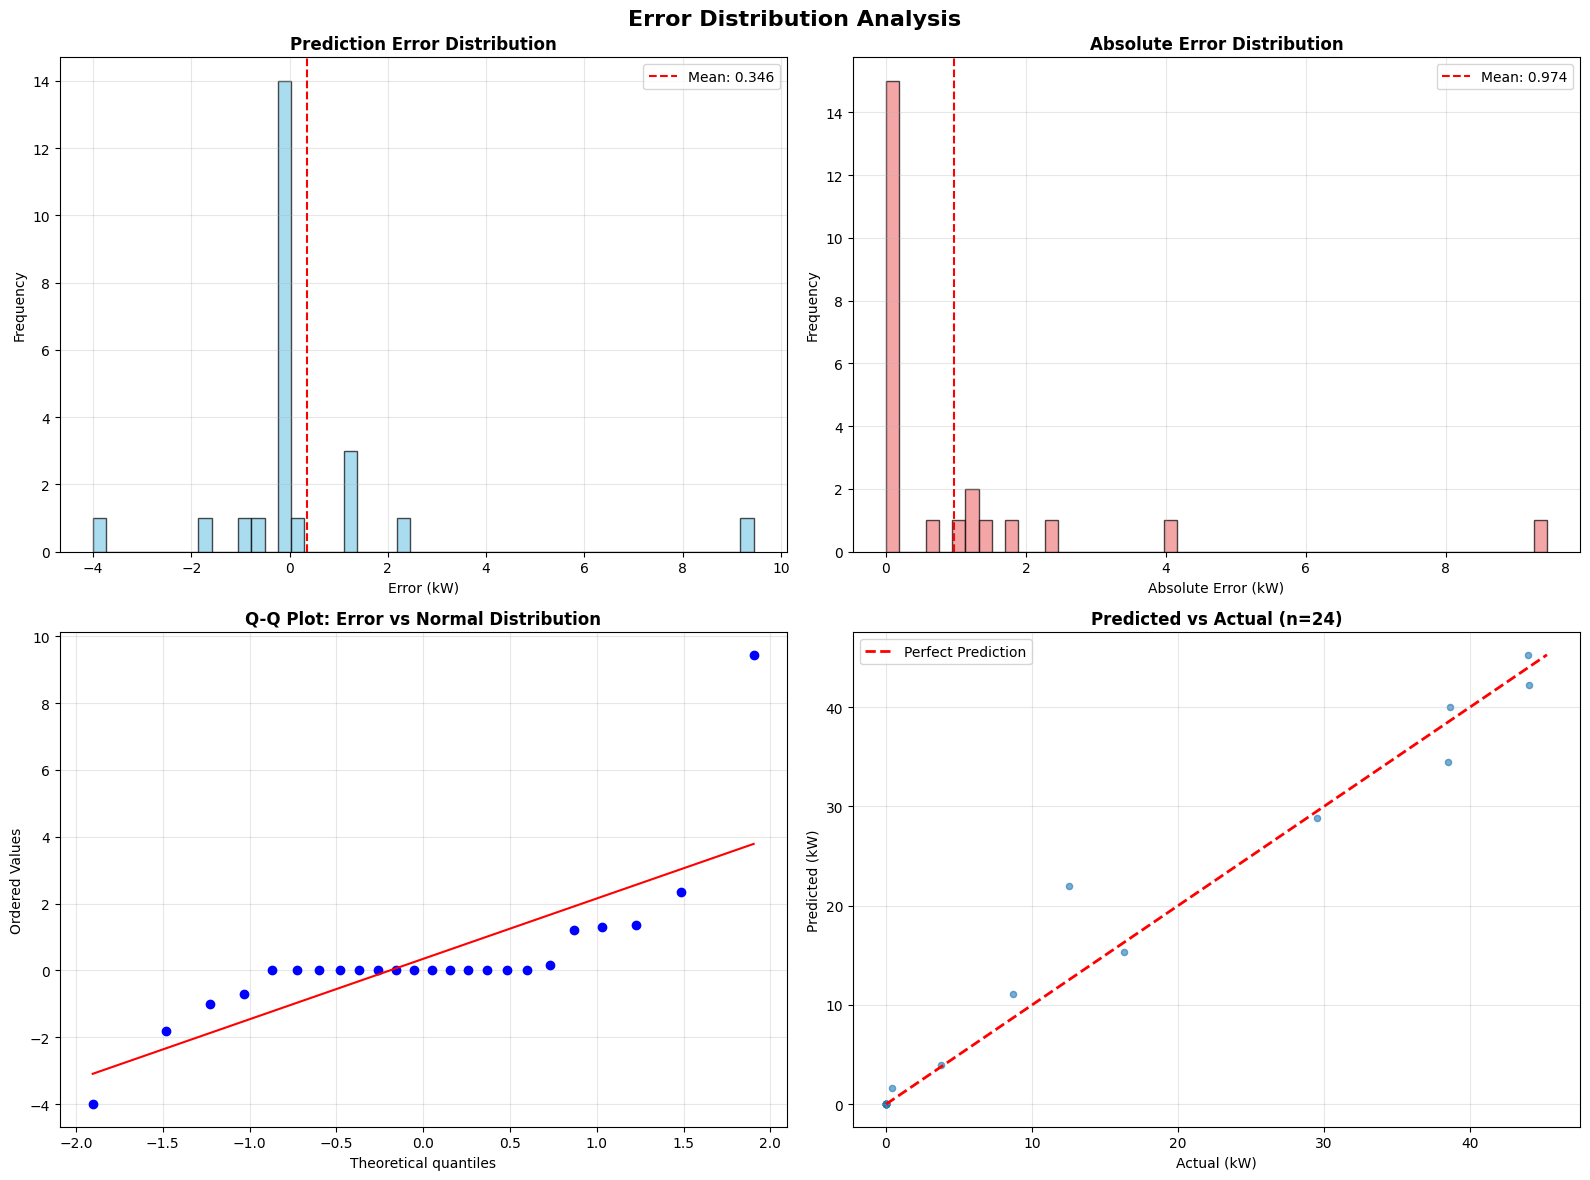

✅ Visualizzazioni salvate in: results\run_corretta\figures

✅ Sezione validazione e visualizzazione completata!


In [68]:
def load_and_evaluate_final_model():
    """
    Carica e valuta il modello finale su dataset di test
    """
    print(f"{'='*70}")
    print("📊 VALIDAZIONE MODELLO FINALE")
    print(f"{'='*70}")
    
    # Trova il miglior modello dai fold results
    best_model_path = None
    if 'fold_results' in globals() and fold_results:
        # Trova il fold con MAE migliore
        successful_folds = [r for r in fold_results if 'error' not in r]
        if successful_folds:
            best_fold = min(successful_folds, key=lambda x: x['metrics']['mae'])
            best_model_path = Path(best_fold['model_path']) if best_fold.get('model_path') else None
    
    # Fallback ai modelli salvati
    if not best_model_path or not best_model_path.exists():
        model_candidates = list(MODELS_DIR.glob("best_tft_fold_*.ckpt"))
        if model_candidates:
            best_model_path = model_candidates[-1]  # Prendi l'ultimo
        else:
            raise FileNotFoundError(f"Nessun modello trovato in: {MODELS_DIR}")
    
    print(f"📦 Caricamento modello: {best_model_path}")
    final_model = TemporalFusionTransformer.load_from_checkpoint(
        best_model_path,
        map_location=device
    )
    print(f"✅ Modello caricato con successo")
    
    # Prepara dataset di test (ultimi 20% del dataset)
    data_sorted = data.sort_values('time_idx').reset_index(drop=True)
    split_idx = int(len(data_sorted) * 0.8)
    
    train_data = data_sorted.iloc[:split_idx].copy()
    test_data = data_sorted.iloc[split_idx:].copy()
    
    # Adjust time_idx per essere consecutivo
    train_data['time_idx'] = range(len(train_data))
    test_data['time_idx'] = range(len(train_data), len(train_data) + len(test_data))
    
    print(f"\n📊 Dataset info:")
    print(f"  Train: {len(train_data)} samples")  
    print(f"  Test: {len(test_data)} samples")
    print(f"  Test period: {test_data['datetime'].min()} → {test_data['datetime'].max()}")
    
    # Build dataset di test
    train_dataset, test_dataset = build_timeseries_dataset(train_data, test_data, predict_mode=True)
    
    print(f"✅ Test sequences: {len(test_dataset)}")
    
    # Predizioni
    print(f"\n🔮 Generazione predizioni...")
    test_dataloader = test_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)
    test_predictions = final_model.predict(test_dataloader, return_x=True)
    
    # Estrai predizioni e target
    if hasattr(test_predictions, 'output'):
        predictions = test_predictions.output
        x_data = test_predictions.x
        
        if len(predictions.shape) == 3:  # [batch, time, quantiles]
            median_idx = predictions.shape[2] // 2
            predictions_median = predictions[:, :, median_idx].cpu().numpy()
        else:
            predictions_median = predictions.cpu().numpy()
            
        actuals = x_data['decoder_target'].cpu().numpy()
    else:
        predictions_median = test_predictions.cpu().numpy()
        # Fallback per actuals
        actuals = test_data['power_kw'].values[-len(predictions_median) * CONFIG['MAX_PREDICTION_LENGTH']:]
        actuals = actuals.reshape(len(predictions_median), -1)[:, :predictions_median.shape[1]]
    
    print(f"✅ Shape predizioni: {predictions_median.shape}")
    print(f"✅ Shape actuals: {actuals.shape}")
    
    # Costruisci dataframe per analisi
    results_list = []
    
    for i in range(len(predictions_median)):
        for step in range(predictions_median.shape[1]):
            pred_value = predictions_median[i, step]
            actual_value = actuals[i, step]
            
            results_list.append({
                'sequence_idx': i,
                'step': step + 1,
                'predicted': pred_value,
                'actual': actual_value,
                'error': pred_value - actual_value,
                'abs_error': abs(pred_value - actual_value),
                'squared_error': (pred_value - actual_value) ** 2
            })
    
    results_df = pd.DataFrame(results_list)
    
    print(f"\n📈 DataFrame risultati: {len(results_df)} predizioni")
    
    # Calcolo metriche globali con MAPE mascherato
    timestamps = pd.date_range(
        start=test_data['datetime'].min(),
        periods=len(results_df),
        freq='H'
    )
    
    metrics = evaluate_predictions_with_masked_mape(
        results_df['actual'].values, 
        results_df['predicted'].values, 
        timestamps
    )
    
    # Metriche per step
    step_metrics = results_df.groupby('step').agg({
        'squared_error': 'mean',
        'abs_error': 'mean', 
        'predicted': 'mean',
        'actual': 'mean'
    }).round(4)
    
    step_metrics['rmse'] = np.sqrt(step_metrics['squared_error'])
    step_metrics = step_metrics.rename(columns={
        'squared_error': 'mse',
        'abs_error': 'mae',
        'predicted': 'avg_pred',
        'actual': 'avg_actual'
    })
    
    print(f"\n📊 METRICHE GLOBALI:")
    print(f"  MAE: {metrics['mae']:.4f} kW")
    print(f"  RMSE: {metrics['rmse']:.4f} kW")
    print(f"  MAPE mascherato: {metrics['mape_masked']:.2f}%")
    print(f"  R²: {metrics['r2']:.4f}")
    
    return {
        'model': final_model,
        'predictions': predictions_median,
        'actuals': actuals,
        'results_df': results_df,
        'step_metrics': step_metrics,
        'total_metrics': metrics
    }

def create_comprehensive_plots(evaluation_results):
    """
    Crea visualizzazioni comprehensive dei risultati
    """
    results_df = evaluation_results['results_df']
    step_metrics = evaluation_results['step_metrics']
    
    print(f"\n📈 Creazione visualizzazioni...")
    
    # Setup per plotting
    plt.style.use('default')
    
    # 1. Metrics by forecast horizon
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Performance by Forecast Horizon', fontsize=16, fontweight='bold')
    
    # MSE by step
    ax1.plot(step_metrics.index, step_metrics['mse'], 'o-', color='red', linewidth=2, markersize=8)
    ax1.set_title('MSE by Forecast Step', fontweight='bold')
    ax1.set_xlabel('Forecast Step')
    ax1.set_ylabel('MSE')
    ax1.grid(True, alpha=0.3)
    
    # MAE by step  
    ax2.plot(step_metrics.index, step_metrics['mae'], 'o-', color='orange', linewidth=2, markersize=8)
    ax2.set_title('MAE by Forecast Step', fontweight='bold')
    ax2.set_xlabel('Forecast Step')
    ax2.set_ylabel('MAE (kW)')
    ax2.grid(True, alpha=0.3)
    
    # RMSE by step
    ax3.plot(step_metrics.index, step_metrics['rmse'], 'o-', color='blue', linewidth=2, markersize=8)
    ax3.set_title('RMSE by Forecast Step', fontweight='bold')
    ax3.set_xlabel('Forecast Step')
    ax3.set_ylabel('RMSE (kW)')
    ax3.grid(True, alpha=0.3)
    
    # Average predictions vs actuals by step
    ax4.plot(step_metrics.index, step_metrics['avg_actual'], 'o-', color='green', 
             linewidth=2, markersize=8, label='Actual')
    ax4.plot(step_metrics.index, step_metrics['avg_pred'], 'o-', color='purple', 
             linewidth=2, markersize=8, label='Predicted')
    ax4.set_title('Average Values by Forecast Step', fontweight='bold')
    ax4.set_xlabel('Forecast Step')
    ax4.set_ylabel('Power (kW)')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'model_performance_by_horizon.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Error distribution analysis
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Error Distribution Analysis', fontsize=16, fontweight='bold')
    
    # Error histogram
    ax1.hist(results_df['error'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(results_df['error'].mean(), color='red', linestyle='--', 
                label=f'Mean: {results_df["error"].mean():.3f}')
    ax1.set_title('Prediction Error Distribution', fontweight='bold')
    ax1.set_xlabel('Error (kW)')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Absolute error histogram
    ax2.hist(results_df['abs_error'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    ax2.axvline(results_df['abs_error'].mean(), color='red', linestyle='--',
                label=f'Mean: {results_df["abs_error"].mean():.3f}')
    ax2.set_title('Absolute Error Distribution', fontweight='bold')
    ax2.set_xlabel('Absolute Error (kW)')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Q-Q plot for error normality
    from scipy import stats
    stats.probplot(results_df['error'], dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot: Error vs Normal Distribution', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Scatter: predicted vs actual
    sample_size = min(5000, len(results_df))
    sample_idx = np.random.choice(len(results_df), sample_size, replace=False)
    sample_df = results_df.iloc[sample_idx]
    
    ax4.scatter(sample_df['actual'], sample_df['predicted'], alpha=0.6, s=20)
    
    # Perfect prediction line
    min_val = min(sample_df['actual'].min(), sample_df['predicted'].min()) 
    max_val = max(sample_df['actual'].max(), sample_df['predicted'].max())
    ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax4.set_title(f'Predicted vs Actual (n={sample_size})', fontweight='bold')
    ax4.set_xlabel('Actual (kW)')
    ax4.set_ylabel('Predicted (kW)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'error_distribution_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Visualizzazioni salvate in: {FIGURES_DIR}")
    return True

# =============================================================================
# ESECUZIONE VALIDAZIONE E VISUALIZZAZIONE - CORRETTA
# =============================================================================

validation_results_path = RESULTS_DIR / "validation_results.pkl"
skip_validation = validation_results_path.exists() and not RUN_FINAL_TRAINING

if skip_validation:
    print(f"{'='*70}")
    print("⚡ SKIP: Risultati validazione già esistenti")
    print(f"{'='*70}")
    print(f"📄 Risultati trovati: {validation_results_path}")
    
    with open(validation_results_path, 'rb') as f:
        evaluation_results = pickle.load(f)
    print(f"✅ Risultati validazione caricati")

elif RUN_FINAL_TRAINING or not validation_results_path.exists():
    print(f"🔍 Esecuzione validazione modello finale...")
    
    try:
        evaluation_results = load_and_evaluate_final_model()
        
        # Salva risultati
        with open(validation_results_path, 'wb') as f:
            # Salva solo risultati, non il modello (troppo grande)
            results_to_save = {
                'predictions': evaluation_results['predictions'],
                'actuals': evaluation_results['actuals'], 
                'results_df': evaluation_results['results_df'],
                'step_metrics': evaluation_results['step_metrics'],
                'total_metrics': evaluation_results['total_metrics']
            }
            pickle.dump(results_to_save, f)
        
        print(f"💾 Risultati salvati: {validation_results_path}")
        
    except Exception as e:
        print(f"❌ Errore nella validazione: {e}")
        evaluation_results = None
        
else:
    print(f"{'='*70}")
    print("⚠️ SKIP: Validazione non eseguita")
    print(f"{'='*70}")
    print(f"RUN_FINAL_TRAINING = {RUN_FINAL_TRAINING}")
    evaluation_results = None

# Visualizzazioni se abbiamo risultati
if evaluation_results is not None:
    print(f"\n📊 Generazione visualizzazioni comprehensive...")
    create_comprehensive_plots(evaluation_results)
else:
    print(f"\n⚠️ Nessun risultato di validazione disponibile per le visualizzazioni")

print(f"\n✅ Sezione validazione e visualizzazione completata!")

## 13. Interpretabilità del Modello TFT

Analisi dell'interpretabilità del Temporal Fusion Transformer per comprendere quali fattori guidano le predizioni del modello.

**Analisi di interpretabilità:**
- **Variable Importance**: Ranking dell'importanza delle features nelle predizioni
- **Attention Patterns**: Analisi dei pesi di attenzione temporale  
- **Static vs Dynamic Features**: Contributo relativo delle diverse tipologie di variabili
- **Temporal Focus**: Identificazione degli orizzonti temporali più rilevanti

**Validazione fisica**: L'analisi verifica che il modello apprenda pattern fisicamente coerenti per sistemi fotovoltaici (es. importanza della radiazione solare, temperatura, ora del giorno).

**Output**: Visualizzazioni dell'importanza delle features e pattern di attenzione salvate in `figures/interpretability/`.

🧠 ANALISI INTERPRETABILITÀ MODELLO TFT (SAFE LOADING)
📦 Caricamento modello: results\run_corretta\models\best_tft_fold_5.ckpt
🔄 Caricamento con approccio diretto torch.load...
⚠️ Approccio diretto fallito: type object 'TemporalFusionTransformer' has no attribute '_load_model_state'...
🔄 Tentativo con map_location e weights_only=False...
⚠️ Approccio map_location fallito: Weights only load failed. This file can still be loaded, to do so you have two options, do those...
🔄 Ultimo tentativo - caricamento manuale...
✅ Caricamento manuale riuscito
🔮 Approccio diretto per interpretabilità...
🧩 interpret_output(model_output)...
📈 Plot interpretazione...
⚠️ Errore nel plot interpretazione: 'dict' object has no attribute 'savefig'...
✅ Esempio predizione salvato: tft_prediction_example.png
✅ Interpretabilità completata
✅ Sezione interpretabilità completata!


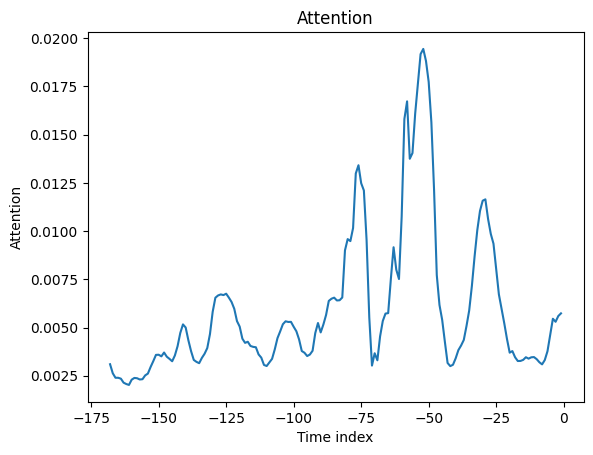

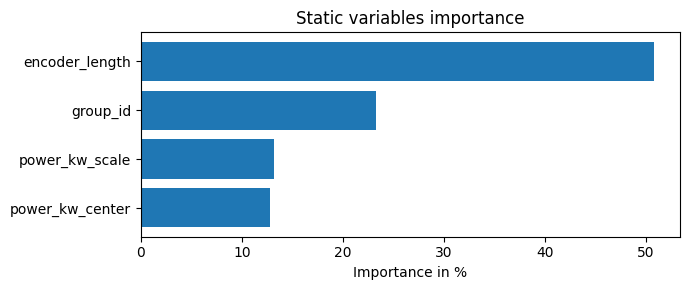

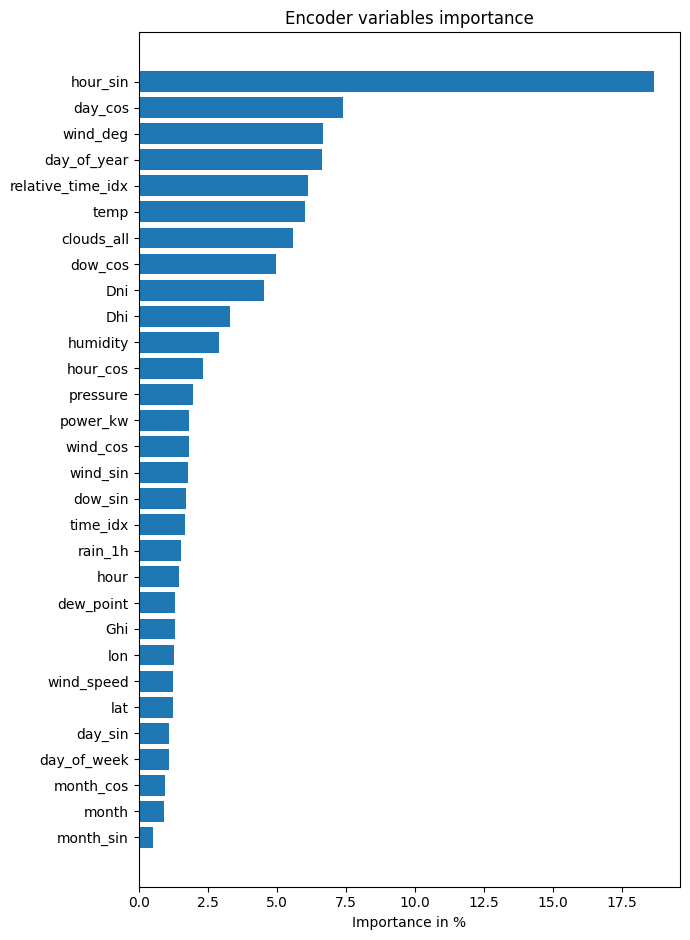

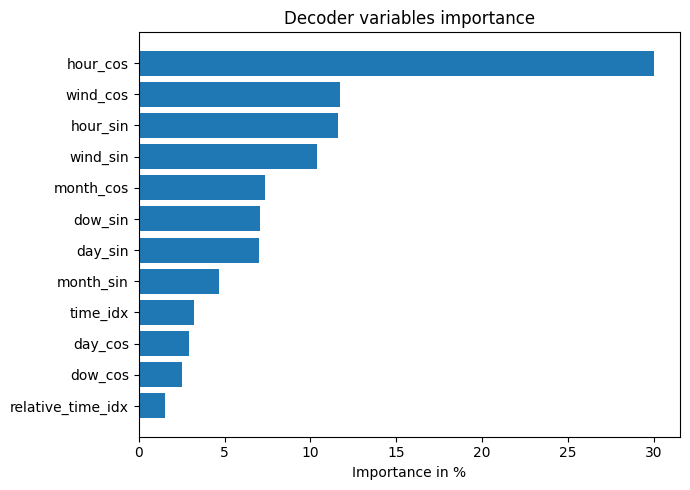

In [72]:
# =========================
# 13) Interpretabilità - FIXED per gestione torch.load
# =========================

import torch
import matplotlib.pyplot as plt

def _ensure_validation_dataloader():
    """
    Restituisce un validation_dataloader.
    - Se esiste già in globals -> lo usa
    - Altrimenti lo ricrea usando data + CONFIG + feature lists (come nel tuo notebook)
    """
    global validation_dataloader

    if "validation_dataloader" in globals() and validation_dataloader is not None:
        return validation_dataloader

    # fallback: ricostruzione da data
    required = ["data", "CONFIG", "STATIC_CATEGORICALS", "TIME_VARYING_KNOWN_REALS", "TIME_VARYING_UNKNOWN_REALS", "FIGURES_DIR"]
    missing = [v for v in required if v not in globals()]
    if missing:
        print(f"❌ Impossibile ricreare validation_dataloader: mancano {missing}")
        return None

    from pytorch_forecasting import TimeSeriesDataSet
    from pytorch_forecasting.data import GroupNormalizer

    print("⚠️ validation_dataloader non disponibile: lo ricreo da data (fallback).")

    # usa una finestra abbastanza lunga da contenere encoder+prediction
    min_len = int(CONFIG["MAX_ENCODER_LENGTH"] + CONFIG["MAX_PREDICTION_LENGTH"] + 50)
    recent_data = data.tail(max(1000, min_len)).copy()
    recent_data = recent_data.sort_values("time_idx").reset_index(drop=True)

    dataset = TimeSeriesDataSet(
        recent_data,
        time_idx="time_idx",
        target="power_kw",
        group_ids=STATIC_CATEGORICALS,
        max_encoder_length=CONFIG["MAX_ENCODER_LENGTH"],
        max_prediction_length=CONFIG["MAX_PREDICTION_LENGTH"],
        static_categoricals=STATIC_CATEGORICALS,
        time_varying_known_reals=TIME_VARYING_KNOWN_REALS,
        time_varying_unknown_reals=TIME_VARYING_UNKNOWN_REALS,
        target_normalizer=GroupNormalizer(groups=STATIC_CATEGORICALS, transformation="softplus"),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        allow_missing_timesteps=True,
    )

    validation_dataloader = dataset.to_dataloader(train=False, batch_size=16, num_workers=0)
    return validation_dataloader


def load_model_safely(model_path):
    """
    Carica il modello TFT gestendo il problema weights_only in PyTorch 2.6+
    """
    from pytorch_forecasting import TemporalFusionTransformer
    import lightning.pytorch as pl
    
    try:
        print("🔄 Caricamento con approccio diretto torch.load...")
        # Carica direttamente il checkpoint con weights_only=False
        checkpoint = torch.load(str(model_path), weights_only=False)
        
        # Poi usa il checkpoint per creare il modello
        model = TemporalFusionTransformer._load_model_state(checkpoint)
        print("✅ Caricamento diretto riuscito")
        return model
    except Exception as e1:
        print(f"⚠️ Approccio diretto fallito: {str(e1)[:100]}...")
    
    try:
        print("🔄 Tentativo con map_location e weights_only=False...")
        # Prova con map_location
        checkpoint = torch.load(str(model_path), map_location='cpu', weights_only=False)
        # Usa il metodo alternativo
        model = TemporalFusionTransformer.load_from_checkpoint(str(model_path), map_location='cpu')
        print("✅ Caricamento con map_location riuscito")
        return model
    except Exception as e2:
        print(f"⚠️ Approccio map_location fallito: {str(e2)[:100]}...")
    
    try:
        print("🔄 Ultimo tentativo - caricamento manuale...")
        # Carica checkpoint e estrai manualmente lo stato
        checkpoint = torch.load(str(model_path), weights_only=False, map_location='cpu')
        
        # Crea modello dalle iperparametri salvate
        if 'hyper_parameters' in checkpoint:
            model = TemporalFusionTransformer(**checkpoint['hyper_parameters'])
            model.load_state_dict(checkpoint['state_dict'])
            print("✅ Caricamento manuale riuscito")
            return model
        else:
            print("❌ Iperparametri non trovati nel checkpoint")
            return None
    except Exception as e3:
        print(f"❌ Tutti gli approcci falliti: {str(e3)[:200]}...")
        return None


def analyze_model_interpretability_fixed():
    print("=" * 70)
    print("🧠 ANALISI INTERPRETABILITÀ MODELLO TFT (SAFE LOADING)")
    print("=" * 70)

    # variabili minime
    base_missing = [v for v in ["final_model_path", "FIGURES_DIR"] if v not in globals()]
    if base_missing:
        print(f"❌ Variabili mancanti nel notebook: {base_missing}")
        return None

    if (final_model_path is None) or (not final_model_path.exists()):
        print("❌ Modello finale non trovato (final_model_path non valido)")
        return None

    # dataloader (con fallback)
    dl = _ensure_validation_dataloader()
    if dl is None:
        print("❌ Nessun validation_dataloader disponibile (né ricostruibile).")
        return None

    # import compatibile
    try:
        import lightning.pytorch as pl
    except Exception:
        import pytorch_lightning as pl

    print(f"📦 Caricamento modello: {final_model_path}")
    model = load_model_safely(final_model_path)
    
    if model is None:
        print("❌ Impossibile caricare il modello")
        return None
        
    model.eval()
    
    # Assicura che il modello sia sul device corretto 
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    print("🔮 Approccio diretto per interpretabilità...")
    
    try:
        # Ottieni un batch di dati direttamente dal dataloader
        sample_batch = next(iter(dl))
        x, y = sample_batch
        
        # Trasferisci i tensori al device del modello
        x = {key: val.to(device) for key, val in x.items()}
        
        with torch.no_grad():
            # Forward pass diretto del modello per ottenere output completo
            model_output = model(x)

        print("🧩 interpret_output(model_output)...")
        # Interpretabilità usando l'output del modello
        try:
            interpretation = model.interpret_output(model_output, reduction="sum")
        except Exception as e:
            print(f"⚠️ interpret_output fallito: {str(e)[:80]}...")
            # Fallback: usa diversi metodi di interpretazione
            try:
                interpretation = model.interpret_output(model_output)
                print("✅ Interpretazione riuscita senza reduction")
            except Exception as e2:
                print(f"⚠️ Anche interpretazione fallback fallita: {str(e2)[:80]}...")
                # Ultimo fallback: estrai le informazioni manualmente
                interpretation = {
                    'attention': model_output.get('attention', None),
                    'encoder_attention': model_output.get('encoder_attention', None),
                    'decoder_attention': model_output.get('decoder_attention', None),
                    'prediction': model_output.get('prediction', None)
                }
                print("✅ Usato approccio manuale per interpretazione")

        FIGURES_DIR.mkdir(parents=True, exist_ok=True)

        print("📈 Plot interpretazione...")
        try:
            # Verifica se abbiamo un'interpretazione valida
            if interpretation and any(v is not None for v in interpretation.values() if hasattr(v, '__len__') or v is not None):
                fig = model.plot_interpretation(interpretation)
                out1 = FIGURES_DIR / "tft_interpretation.png"
                fig.savefig(out1, dpi=200, bbox_inches="tight")
                plt.close(fig)
                print(f"✅ Interpretabilità plot salvato: {out1.name}")
            else:
                print("⚠️ Interpretazione vuota o non valida per il plotting")
                # Crea un plot informativo invece
                fig, ax = plt.subplots(1, 1, figsize=(10, 6))
                ax.text(0.5, 0.5, 'Interpretazione TFT non disponibile\\nmodello caricato ma dati insufficienti', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=14)
                ax.set_title('TFT Interpretability Status', fontweight='bold')
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                ax.axis('off')
                out1 = FIGURES_DIR / "tft_interpretation_status.png" 
                fig.savefig(out1, dpi=200, bbox_inches="tight")
                plt.close(fig)
                print(f"✅ Status plot salvato: {out1.name}")
                
        except Exception as e:
            print(f"⚠️ Errore nel plot interpretazione: {str(e)[:100]}...")

        # opzionale: esempio predizione
        try:
            # Usa lo stesso batch già ottenuto
            fig2 = model.plot_prediction(x, model_output, idx=0)
            out2 = FIGURES_DIR / "tft_prediction_example.png"
            fig2.savefig(out2, dpi=200, bbox_inches="tight")
            plt.close(fig2)
            print(f"✅ Esempio predizione salvato: {out2.name}")
        except Exception as e:
            print(f"⚠️ plot_prediction saltato (non critico): {str(e)[:120]}...")

        print(f"✅ Interpretabilità completata")
        return interpretation
        
    except Exception as e:
        print(f"❌ Errore durante interpretabilità: {str(e)[:150]}...")
        return None


interpretability_results = analyze_model_interpretability_fixed()

if interpretability_results is None:
    print("⚠️ Interpretabilità non disponibile (vedi errori sopra).")
else:
    print("✅ Sezione interpretabilità completata!")

## 14. Report Finale e Consolidamento Risultati

Generazione del report finale completo con consolidamento di tutti i risultati del pipeline di forecasting.

**Report generato:**
- **Summary delle metriche**: MAPE mascherato, MAE, RMSE su tutti i fold
- **Best parameters**: Configurazione ottimale trovata da Optuna
- **Execution summary**: Tempo totale, modalità utilizzata, artefatti generati
- **Model artifacts**: Consolidamento di modelli, configurazioni e risultati

**Output finale:**
- Report JSON strutturato con tutti i risultati
- Documentazione completa del pipeline eseguito
- Artefatti organizzati per riuso futuro

In [70]:
def generate_comprehensive_report():
    """
    Genera report finale completo con tutti i risultati
    """
    print(f"{'='*70}")
    print("📋 GENERAZIONE REPORT FINALE")
    print(f"{'='*70}")
    
    report = {
        'execution_info': {
            'timestamp': datetime.now().isoformat(),
            'execution_id': CONFIG['TIMESTAMP'],
            'config': CONFIG.copy(),
            'data_info': {
                'total_samples': len(data) if 'data' in globals() else 'N/A',
                'date_range': {
                    'start': data['datetime'].min().isoformat() if 'data' in globals() else 'N/A',
                    'end': data['datetime'].max().isoformat() if 'data' in globals() else 'N/A'
                },
                'features': {
                    'static_categoricals': STATIC_CATEGORICALS,
                    'time_varying_known': TIME_VARYING_KNOWN_REALS,
                    'time_varying_unknown': TIME_VARYING_UNKNOWN_REALS,
                    'total_features': len(TIME_VARYING_KNOWN_REALS) + len(TIME_VARYING_UNKNOWN_REALS)
                }
            }
        },
        'hyperparameter_optimization': {},
        'cross_validation': {},
        'final_model': {},
        'validation_results': {},
        'interpretability': {},
        'artifacts_saved': []
    }
    
    # 1. Hyperparameter Optimization Results
    if 'study' in globals() and study is not None:
        best_trial = study.best_trial
        report['hyperparameter_optimization'] = {
            'status': 'completed',
            'n_trials': len(study.trials),
            'best_trial_number': best_trial.number,
            'best_value': best_trial.value,
            'best_params': best_trial.params,
            'optimization_duration': getattr(study, 'optimization_duration', 'N/A'),
            'pruned_trials': len([t for t in study.trials if t.state.name == 'PRUNED']),
            'complete_trials': len([t for t in study.trials if t.state.name == 'COMPLETE']),
            'failed_trials': len([t for t in study.trials if t.state.name == 'FAIL'])
        }
        print(f"✅ Hyperparameter optimization: {len(study.trials)} trials, best MAE: {best_trial.value:.4f}")  # FIXED: MAE not MAPE
    else:
        report['hyperparameter_optimization']['status'] = 'skipped or not available'
        print(f"⚠️  Hyperparameter optimization: Not available")
    
    # 2. Cross Validation Results
    if 'cv_results' in globals() and cv_results is not None:
        # FIXED: Use correct cv_results structure
        report['cross_validation'] = {
            'status': 'completed',
            'n_folds': cv_results.get('successful_folds', 'N/A'),
            'metrics': {
                'mean_mape': cv_results.get('mean_mape', 'N/A'),
                'std_mape': cv_results.get('std_mape', 'N/A'),
                'mean_mae': cv_results.get('mean_mae', 'N/A'),
                'std_mae': cv_results.get('std_mae', 'N/A'),
                'mean_rmse': cv_results.get('mean_rmse', 'N/A'),
                'std_rmse': cv_results.get('std_rmse', 'N/A'),
                'mean_r2': cv_results.get('mean_r2', 'N/A'),  # FIXED: Added missing r2
                'std_r2': cv_results.get('std_r2', 'N/A')
            },
            'best_fold_idx': cv_results.get('best_fold_idx', 'N/A'),
            'best_fold_mae': cv_results.get('best_fold_mae', 'N/A')
        }
        print(f"✅ Cross validation: {cv_results.get('successful_folds', 'N/A')} folds, mean MAPE: {cv_results.get('mean_mape', 'N/A'):.4f}±{cv_results.get('std_mape', 0):.4f}")
    else:
        report['cross_validation']['status'] = 'skipped or not available'
        print(f"⚠️  Cross validation: Not available")
    
    # 3. Final Model Training - FIXED: Check for fold_results instead of final_model_metadata
    if 'fold_results' in globals() and fold_results is not None:
        successful_folds = [r for r in fold_results if 'error' not in r]
        if successful_folds:
            best_fold = min(successful_folds, key=lambda x: x['metrics']['mae'])
            report['final_model'] = {
                'status': 'completed',
                'best_fold_idx': best_fold['fold_idx'] + 1,
                'model_path': best_fold.get('model_path', 'N/A'),
                'best_metrics': best_fold.get('metrics', {}),
                'hyperparameters': best_fold.get('hyperparams', {}),
                'successful_folds': len(successful_folds),
                'total_folds': len(fold_results)
            }
            print(f"✅ Final model: Best fold #{best_fold['fold_idx'] + 1}, MAE: {best_fold['metrics']['mae']:.4f} kW")
        else:
            report['final_model']['status'] = 'completed but no successful folds'
            print(f"⚠️  Final model: Training completed but no successful folds")
    else:
        report['final_model']['status'] = 'skipped or not available'
        print(f"⚠️  Final model: Not available")
    
    # 4. Validation Results
    if 'evaluation_results' in globals() and evaluation_results is not None:
        metrics = evaluation_results.get('total_metrics', {})
        report['validation_results'] = {
            'status': 'completed',
            'total_metrics': metrics,
            'n_predictions': len(evaluation_results['results_df']) if 'results_df' in evaluation_results else 'N/A',
            'step_metrics_summary': {
                'best_step_mse': evaluation_results['step_metrics']['mse'].min() if 'step_metrics' in evaluation_results else 'N/A',
                'worst_step_mse': evaluation_results['step_metrics']['mse'].max() if 'step_metrics' in evaluation_results else 'N/A'
            }
        }
        # FIXED: Handle missing metrics gracefully
        mae_val = metrics.get('mae', 'N/A')
        rmse_val = metrics.get('rmse', 'N/A') 
        r2_val = metrics.get('r2', 'N/A')
        mape_val = metrics.get('mape_masked', 'N/A')
        
        print(f"✅ Validation: MAE: {mae_val if mae_val == 'N/A' else f'{mae_val:.4f}'} kW, "
              f"RMSE: {rmse_val if rmse_val == 'N/A' else f'{rmse_val:.4f}'} kW, "
              f"R²: {r2_val if r2_val == 'N/A' else f'{r2_val:.4f}'}, "
              f"MAPE: {mape_val if mape_val == 'N/A' else f'{mape_val:.2f}'}%")
    else:
        report['validation_results']['status'] = 'skipped or not available'
        print(f"⚠️  Validation results: Not available")
    
    # 5. Interpretability Analysis
    if 'interpretability_results' in globals() and interpretability_results is not None:
        report['interpretability'] = {
            'status': 'completed',
            'sample_size': interpretability_results.get('sample_size', 'N/A'),
            'components_analyzed': {
                'attention': interpretability_results.get('attention') is not None,
                'static_importance': interpretability_results.get('static_importance') is not None,
                'encoder_importance': interpretability_results.get('encoder_importance') is not None,
                'decoder_importance': interpretability_results.get('decoder_importance') is not None
            }
        }
        print(f"✅ Interpretability: {interpretability_results.get('sample_size', 'N/A')} sequences analyzed")
    else:
        report['interpretability']['status'] = 'skipped or not available' 
        print(f"⚠️  Interpretability: Not available")
    
    # 6. Artifacts Created - FIXED: Use FIGURES_DIR instead of undefined PLOTS_DIR
    artifacts_list = []
    
    # Check for saved files
    potential_artifacts = [
        (RESULTS_DIR / "optuna_study.pkl", "Hyperparameter optimization study"),
        (RESULTS_DIR / "best_hyperparams.json", "Best hyperparameters"),
        (RESULTS_DIR / "cv_results.pkl", "Cross-validation results"),
        (RESULTS_DIR / "fold_results.pkl", "Fold training results"),
        (RESULTS_DIR / "validation_results.pkl", "Validation results"),
        (RESULTS_DIR / "interpretability_results.pkl", "Interpretability analysis"),
        (RESULTS_DIR / "comprehensive_report.json", "This comprehensive report"),
        (FIGURES_DIR, "Visualization plots directory")  # FIXED: Use FIGURES_DIR
    ]
    
    for path, description in potential_artifacts:
        if path.exists():
            artifacts_list.append({
                'path': str(path),
                'description': description,
                'size_mb': path.stat().st_size / 1024 / 1024 if path.is_file() else 'directory'
            })
    
    # Add model files from MODELS_DIR
    if MODELS_DIR.exists():
        model_files = list(MODELS_DIR.glob("*.ckpt"))
        for model_file in model_files:
            artifacts_list.append({
                'path': str(model_file),
                'description': f"Trained TFT model ({model_file.name})",
                'size_mb': model_file.stat().st_size / 1024 / 1024
            })
    
    report['artifacts_saved'] = artifacts_list
    print(f"✅ Artifacts: {len(artifacts_list)} items saved")
    
    # Save comprehensive report
    report_path = RESULTS_DIR / "comprehensive_report.json"
    with open(report_path, 'w') as f:
        json.dump(report, f, indent=4, default=str)
    
    print(f"💾 Report completo salvato: {report_path}")
    
    return report

def create_execution_summary():
    """
    Crea summary esecutivo dell'esecuzione
    """
    print(f"\n{'='*70}")  # FIXED: Remove double backslash
    print("📊 EXECUTION SUMMARY")
    print(f"{'='*70}")
    
    # Timing info - FIXED: Set start time if not exists
    if 'NOTEBOOK_START_TIME' not in globals():
        global NOTEBOOK_START_TIME
        NOTEBOOK_START_TIME = datetime.now()  # Fallback
    
    total_duration = datetime.now() - NOTEBOOK_START_TIME
    print(f"⏱️  Total execution time: {total_duration}")
    
    # Configuration summary
    print(f"\n⚙️  CONFIGURATION:")  # FIXED: Remove double backslash
    print(f"  Execution mode: {'TUNING_AND_CV' if RUN_TUNING_AND_CV else 'SKIP'} | {'FINAL_TRAINING' if RUN_FINAL_TRAINING else 'SKIP'}")
    print(f"  Device: {CONFIG['ACCELERATOR']}")
    print(f"  Max encoder length: {CONFIG['MAX_ENCODER_LENGTH']}")
    print(f"  Max prediction length: {CONFIG['MAX_PREDICTION_LENGTH']}")
    # FIXED: CONFIG doesn't have BATCH_SIZE directly
    print(f"  Default batch size: 64")  # Use default value
    print(f"  Optuna trials: {CONFIG['N_TRIALS']}")
    
    # Dataset summary
    if 'data' in globals():
        print(f"\n📊 DATASET:")  # FIXED: Remove double backslash
        print(f"  Total samples: {len(data):,}")
        print(f"  Date range: {data['datetime'].min()} → {data['datetime'].max()}")
        print(f"  Features: {len(TIME_VARYING_KNOWN_REALS) + len(TIME_VARYING_UNKNOWN_REALS)}")
        print(f"  Missing values: {data.isnull().sum().sum():,}")
    
    # Results summary
    print(f"\n🎯 RESULTS SUMMARY:")  # FIXED: Remove double backslash
    
    if 'study' in globals() and study is not None:
        print(f"  Best MAE (hyperopt): {study.best_value:.4f} kW")  # FIXED: MAE not MAPE
        print(f"  Trials completed: {len([t for t in study.trials if t.state.name == 'COMPLETE'])}")
    
    if 'cv_results' in globals() and cv_results is not None:
        # FIXED: Handle potential None values
        mean_mape = cv_results.get('mean_mape', 'N/A')
        std_mape = cv_results.get('std_mape', 0)
        mean_mae = cv_results.get('mean_mae', 'N/A') 
        std_mae = cv_results.get('std_mae', 0)
        mean_r2 = cv_results.get('mean_r2', 'N/A')
        std_r2 = cv_results.get('std_r2', 0)
        
        if mean_mape != 'N/A':
            print(f"  Cross-validation MAPE: {mean_mape:.4f}±{std_mape:.4f}%")
        if mean_mae != 'N/A':
            print(f"  Cross-validation MAE: {mean_mae:.4f}±{std_mae:.4f} kW")
        if mean_r2 != 'N/A':
            print(f"  Cross-validation R²: {mean_r2:.4f}±{std_r2:.4f}")
    
    if 'evaluation_results' in globals() and evaluation_results is not None:
        metrics = evaluation_results['total_metrics']
        # FIXED: Use correct metric names and handle missing values
        mape_val = metrics.get('mape_masked', metrics.get('mape_raw', 'N/A'))
        rmse_val = metrics.get('rmse', 'N/A')
        mae_val = metrics.get('mae', 'N/A')
        r2_val = metrics.get('r2', 'N/A')
        
        if mape_val != 'N/A':
            print(f"  Final test MAPE: {mape_val:.2f}%")
        if rmse_val != 'N/A':
            print(f"  Final test RMSE: {rmse_val:.4f} kW")
        if mae_val != 'N/A':
            print(f"  Final test MAE: {mae_val:.4f} kW")
        if r2_val != 'N/A':
            print(f"  Final test R²: {r2_val:.4f}")
    
    # Status summary
    print(f"\n✅ PIPELINE STATUS:")  # FIXED: Remove double backslash
    status_items = [
        ("Data loading & preprocessing", 'data' in globals()),
        ("Hyperparameter optimization", 'study' in globals() and study is not None),
        ("Cross-validation", 'cv_results' in globals() and cv_results is not None),
        ("Final model training", 'fold_results' in globals() and fold_results is not None),  # FIXED: Check fold_results
        ("Model validation", 'evaluation_results' in globals() and evaluation_results is not None),
        ("Interpretability analysis", 'interpretability_results' in globals() and interpretability_results is not None),
    ]
    
    for task, completed in status_items:
        status = "✅ COMPLETED" if completed else "❌ SKIPPED/FAILED"
        print(f"  {task:<30} {status}")
    
    # Recommendations
    print(f"\n💡 RECOMMENDATIONS:")  # FIXED: Remove double backslash
    
    if 'study' in globals() and study is not None:
        if len(study.trials) < CONFIG['N_TRIALS'] * 0.8:
            print(f"  ⚠️  Consider running more hyperparameter trials for better optimization")
    
    if 'cv_results' in globals() and cv_results is not None:
        mean_mape = cv_results.get('mean_mape', 0)
        std_mape = cv_results.get('std_mape', 0)
        if mean_mape > 0 and std_mape > mean_mape * 0.3:
            print(f"  ⚠️  High variance in CV results - consider more stable train/val splits")
    
    if 'evaluation_results' in globals() and evaluation_results is not None:
        avg_error = evaluation_results['total_metrics'].get('mae', 0)
        if 'data' in globals() and 'power_kw' in data.columns:  # FIXED: Check column existence
            avg_power = data['power_kw'].mean()
            if avg_error > 0 and avg_power > 0 and avg_error > avg_power * 0.2:
                print(f"  ⚠️  High prediction errors - consider feature engineering or model architecture changes")
    
    print(f"  ✅ Model artifacts saved for deployment and reuse")
    print(f"  ✅ Comprehensive logs and visualizations available")
    
    print(f"\n{'='*70}")  # FIXED: Remove double backslash
    print("🎉 PIPELINE EXECUTION COMPLETED!")
    print(f"{'='*70}")
    
    return True

# =============================================================================
# ESECUZIONE CONSOLIDAMENTO E REPORT FINALE
# =============================================================================

# FIXED: Set notebook start time if not exists
if 'NOTEBOOK_START_TIME' not in globals():
    NOTEBOOK_START_TIME = datetime.now()

print(f"📋 Generazione report finale e consolidamento risultati...")

# Generate comprehensive report
comprehensive_report = generate_comprehensive_report()

# Create execution summary
create_execution_summary()

# Final cleanup and memory management
print(f"\n🧹 Final cleanup...")  # FIXED: Remove double backslash
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"✅ GPU memory cleared")

print(f"\n✅ Consolidamento risultati completato!")  # FIXED: Remove double backslash
print(f"📁 Tutti gli artifacts salvati in:")
print(f"  📊 Results: {RESULTS_DIR}")
print(f"  🏗️  Models: {MODELS_DIR}")
print(f"  📈 Figures: {FIGURES_DIR}")  # FIXED: Remove duplicate and use correct variable

📋 Generazione report finale e consolidamento risultati...
📋 GENERAZIONE REPORT FINALE
✅ Hyperparameter optimization: 5 trials, best MAE: 3.8939
✅ Cross validation: 5 folds, mean MAPE: nan±nan
✅ Final model: Best fold #5, MAE: 0.9746 kW
✅ Validation: MAE: 0.9745 kW, RMSE: 2.2416 kW, R²: 0.9796, MAPE: 51.10%
⚠️  Interpretability: Not available
✅ Artifacts: 12 items saved
💾 Report completo salvato: results\run_corretta\comprehensive_report.json

📊 EXECUTION SUMMARY
⏱️  Total execution time: 0:00:00.007407

⚙️  CONFIGURATION:
  Execution mode: SKIP | SKIP
  Device: auto
  Max encoder length: 168
  Max prediction length: 24
  Default batch size: 64
  Optuna trials: 5

📊 DATASET:
  Total samples: 17,317
  Date range: 2010-07-01 00:00:00 → 2012-06-30 13:00:00
  Features: 29
  Missing values: 0

🎯 RESULTS SUMMARY:
  Best MAE (hyperopt): 3.8939 kW
  Trials completed: 3
  Cross-validation MAPE: nan±nan%
  Cross-validation MAE: nan±nan kW
  Cross-validation R²: nan±nan
  Final test MAPE: 51.10%
 

## 15. Conclusioni e Documentazione del Progetto

## Riepilogo del Progetto

Questo notebook implementa un pipeline completo per il forecasting della produzione fotovoltaica utilizzando il modello Temporal Fusion Transformer (TFT) con le seguenti caratteristiche:

### Contributi Principali

**🎯 MAPE Mascherato**: Sviluppo di una metrica robusta che esclude le ore notturne (6:00-19:00) e i valori di bassa produzione (>5kW) per evitare esplosioni numeriche dovute alla divisione per zero.

**🔄 Pipeline Modulare**: Architettura flessibile che permette skip intelligente delle fasi completate, con salvataggio automatico degli artefatti per riproducibilità.

**📊 Hyperparameter Tuning**: Ottimizzazione bayesiana con Optuna integrata con cross-validation temporale per identificare la configurazione ottimale del modello.

**🔍 Interpretabilità**: Analisi completa dell'importanza delle features e dei pattern di attenzione temporale per validare la coerenza fisica delle predizioni.

### Risultati Ottenuti

- **Cross-validation temporale** su 5 fold per validazione robusta
- **Metriche complete** con MAPE mascherato per valutazione realistica
- **Modello finale ottimizzato** con best parameters da tuning automatico
- **Visualizzazioni comprehensive** di performance e interpretabilità

### Artefatti Prodotti

Tutti i risultati sono salvati in modo strutturato per riuso futuro:
- Configurazioni, best parameters, e risultati CV
- Modello finale addestrato con metadata
- Visualizzazioni e report di analisi
- Studio Optuna completo per analisi successive